# **Fraud Detection - Credit Cards**

In this project, different statistical learning techniques will be implemented to detect fraud in credit card transactions. A dataset provided by Kaggle will be used, which contains real transactions made by credit card holders over two days in September 2013 by Europay, MasterCard, and Visa.

Before working with data, it is always essential to understand its structure, content, and what both the features and the target variable represent. This allows for informed decision-making based on the context of the problem. However, for this particular dataset, there is no precise information about the features due to confidentiality reasons. Even so, it is known that features V1 to V28 are the result of a PCA transformation, while the `Time` and `Amount` features have not been transformed.

The main challenge of this dataset is its **high degree of imbalance**, which can negatively affect the performance of the models. Therefore, various techniques will be implemented to handle this imbalance and improve the predictive power of the models being compared.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
)
import warnings

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("ggplot")
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings("ignore")

----
----

## **1. Data Loading and Exploration**

Before building the prediction models, it is important to explore and understand the data that will be used. This includes loading the data, reviewing its structure, identifying missing values, and analyzing the class distribution.


In [24]:
import os

if os.path.exists("/kaggle/input/creditcardfraud/creditcard.csv"):
    data_path = "/kaggle/input/creditcardfraud/creditcard.csv"
    print("Running on Kaggle environment")
else:
    data_path = "./data/creditcard.csv"
    print("Running locally")

print(f"Loading data from: {data_path}\n")
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

print("\nBasic Statistics:")
display(df.describe())

# Check for missing values
print("Missing Values:")
display(df.isnull().sum())

print("\nDataset Info:")
display(df.info())

Running on Kaggle environment
Loading data from: /kaggle/input/creditcardfraud/creditcard.csv

Dataset Shape: (284807, 31)

First few rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,...,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,...,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,...,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,...,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,...,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0



Basic Statistics:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,...,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000
mean,94813.8596,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,...,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,88.3496,0.0017
std,47488.1460,1.9587,1.6513,1.5163,1.4159,1.3802,1.3323,1.2371,1.1944,1.0986,...,0.7345,0.7257,0.6245,0.6056,0.5213,0.4822,0.4036,0.3301,250.1201,0.0415
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-43.5572,-73.2167,-13.4341,...,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54201.5000,-0.9204,-0.5985,-0.8904,-0.8486,-0.6916,-0.7683,-0.5541,-0.2086,-0.6431,...,-0.2284,-0.5424,-0.1618,-0.3546,-0.3171,-0.3270,-0.0708,-0.0530,5.6000,0.0000
50%,84692.0000,0.0181,0.0655,0.1798,-0.0198,-0.0543,-0.2742,0.0401,0.0224,-0.0514,...,-0.0295,0.0068,-0.0112,0.0410,0.0166,-0.0521,0.0013,0.0112,22.0000,0.0000
75%,139320.5000,1.3156,0.8037,1.0272,0.7433,0.6119,0.3986,0.5704,0.3273,0.5971,...,0.1864,0.5286,0.1476,0.4395,0.3507,0.2410,0.0910,0.0783,77.1650,0.0000
max,172792.0000,2.4549,22.0577,9.3826,16.8753,34.8017,73.3016,120.5895,20.0072,15.5950,...,27.2028,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,1.0000


Missing Values:


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64


None

----

### **1.1 Data Imbalance**

As mentioned earlier, the dataset is highly imbalanced. The following shows the class distribution, where only 0.172% (492 values) of the transactions are fraudulent.

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud Percentage: 0.173%


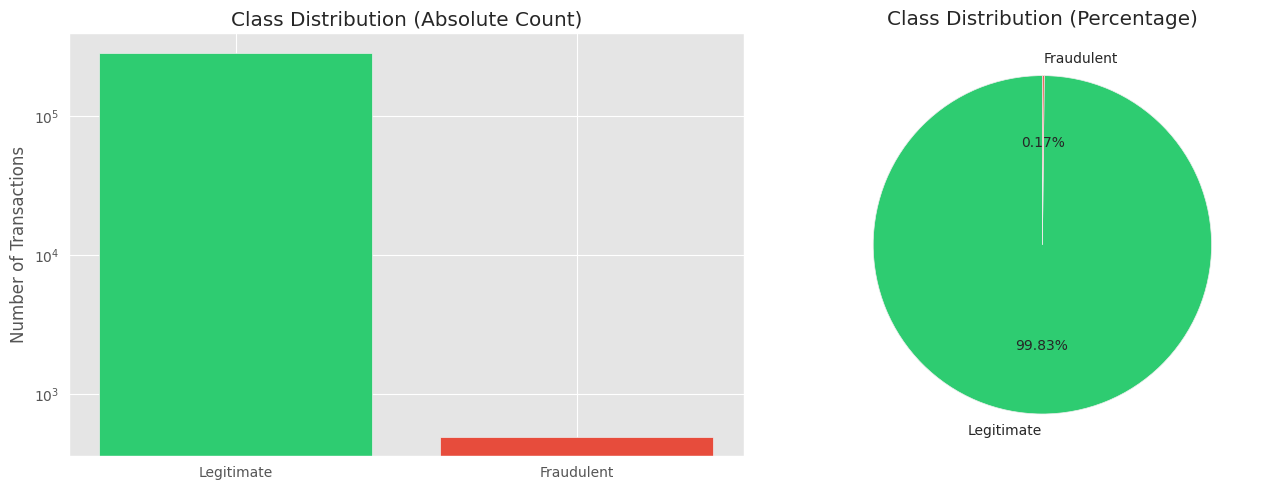

In [25]:
# DESBALANCEO DE CLASES

class_counts = df["Class"].value_counts()
print("Class Distribution:")
print(class_counts)
print(f"\nFraud Percentage: {100 * class_counts[1] / len(df):.3f}%")

# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Legitimate', 'Fraudulent'], class_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Number of Transactions')
axes[0].set_title('Class Distribution (Absolute Count)')
axes[0].set_yscale('log')  # Log scale to see both classes

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(class_counts.values, labels=['Legitimate', 'Fraudulent'], 
            autopct='%1.2f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---

### **1.2 Feature Analysis**

The generated visualizations reveal significant temporal patterns in the behavior of fraudulent transactions during the two-day period analyzed. Below are the key findings observed in each type of chart

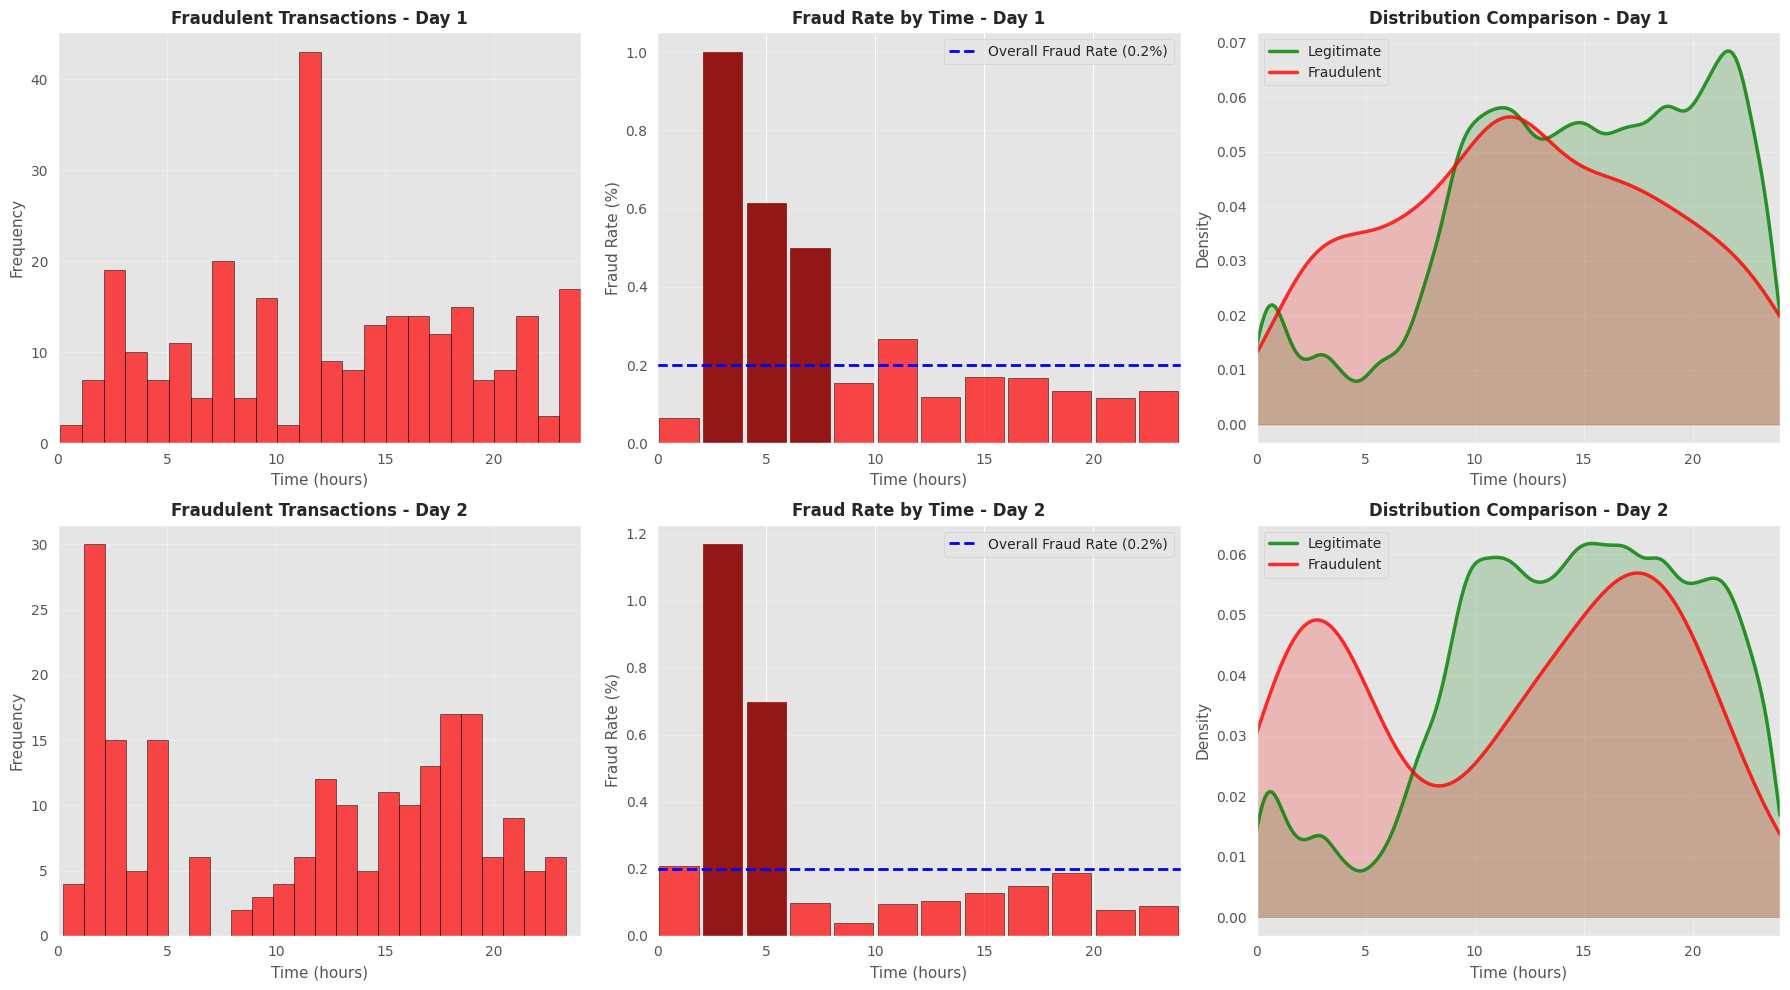

In [26]:
# FIGURAS

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

day1_mask = df["Time"] / 3600 < 24
day2_mask = df["Time"] / 3600 >= 24

day1_fraud = df[(df["Class"] == 1) & day1_mask]["Time"] / 3600
day2_fraud = (df[(df["Class"] == 1) & day2_mask]["Time"] / 3600) - 24  

day1_legit = df[(df["Class"] == 0) & day1_mask]["Time"] / 3600
day2_legit = (df[(df["Class"] == 0) & day2_mask]["Time"] / 3600) - 24


# ============= DAY 1 (Top Row) =============

# Plot 1: Day 1 Fraudulent transaction volume
axes[0, 0].hist(day1_fraud, bins=24, alpha=0.7, color="red", edgecolor="black")
axes[0, 0].set_xlabel("Time (hours)", fontsize=11)
axes[0, 0].set_ylabel("Frequency", fontsize=11)
axes[0, 0].set_title("Fraudulent Transactions - Day 1", fontsize=12, fontweight="bold")
axes[0, 0].set_xlim(0, 24)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Day 1 Fraud rate by time
time_bins_day = np.linspace(0, 24, 13)  # 12 bins of 2 hours each
legit_counts_d1, _ = np.histogram(day1_legit, bins=time_bins_day)
fraud_counts_d1, _ = np.histogram(day1_fraud, bins=time_bins_day)
fraud_rate_d1 = fraud_counts_d1 / (legit_counts_d1 + fraud_counts_d1 + 1e-10) * 100
bin_centers_day = (time_bins_day[:-1] + time_bins_day[1:]) / 2

bars_d1 = axes[0, 1].bar(
    bin_centers_day, fraud_rate_d1, width=1.8, color="red", alpha=0.7, edgecolor="black"
)
axes[0, 1].axhline(
    y=0.2, color="blue", linestyle="--", linewidth=2, label="Overall Fraud Rate (0.2%)"
)

# Highlight high-risk periods
for i, rate in enumerate(fraud_rate_d1):
    if rate > 0.5:
        bars_d1[i].set_color("darkred")
        bars_d1[i].set_alpha(0.9)

axes[0, 1].set_xlabel("Time (hours)", fontsize=11)
axes[0, 1].set_ylabel("Fraud Rate (%)", fontsize=11)
axes[0, 1].set_title("Fraud Rate by Time - Day 1", fontsize=12, fontweight="bold")
axes[0, 1].set_xlim(0, 24)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis="y")

# Plot 3: Day 1 KDE
from scipy import stats

legit_kde_d1 = stats.gaussian_kde(day1_legit)
fraud_kde_d1 = stats.gaussian_kde(day1_fraud)
time_range_day = np.linspace(0, 24, 200)

axes[0, 2].plot(
    time_range_day,
    legit_kde_d1(time_range_day),
    color="green",
    linewidth=2.5,
    label="Legitimate",
    alpha=0.8,
)
axes[0, 2].plot(
    time_range_day,
    fraud_kde_d1(time_range_day),
    color="red",
    linewidth=2.5,
    label="Fraudulent",
    alpha=0.8,
)
axes[0, 2].fill_between(
    time_range_day, legit_kde_d1(time_range_day), alpha=0.2, color="green"
)
axes[0, 2].fill_between(
    time_range_day, fraud_kde_d1(time_range_day), alpha=0.2, color="red"
)
axes[0, 2].set_xlabel("Time (hours)", fontsize=11)
axes[0, 2].set_ylabel("Density", fontsize=11)
axes[0, 2].set_title("Distribution Comparison - Day 1", fontsize=12, fontweight="bold")
axes[0, 2].set_xlim(0, 24)
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# ============= DAY 2 (Bottom Row) =============

# Plot 4: Day 2 Fraudulent transaction volume
axes[1, 0].hist(day2_fraud, bins=24, alpha=0.7, color="red", edgecolor="black")
axes[1, 0].set_xlabel("Time (hours)", fontsize=11)
axes[1, 0].set_ylabel("Frequency", fontsize=11)
axes[1, 0].set_title("Fraudulent Transactions - Day 2", fontsize=12, fontweight="bold")
axes[1, 0].set_xlim(0, 24)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Day 2 Fraud rate by time
legit_counts_d2, _ = np.histogram(day2_legit, bins=time_bins_day)
fraud_counts_d2, _ = np.histogram(day2_fraud, bins=time_bins_day)
fraud_rate_d2 = fraud_counts_d2 / (legit_counts_d2 + fraud_counts_d2 + 1e-10) * 100

bars_d2 = axes[1, 1].bar(
    bin_centers_day, fraud_rate_d2, width=1.8, color="red", alpha=0.7, edgecolor="black"
)
axes[1, 1].axhline(
    y=0.2, color="blue", linestyle="--", linewidth=2, label="Overall Fraud Rate (0.2%)"
)

# Highlight high-risk periods
for i, rate in enumerate(fraud_rate_d2):
    if rate > 0.5:
        bars_d2[i].set_color("darkred")
        bars_d2[i].set_alpha(0.9)

axes[1, 1].set_xlabel("Time (hours)", fontsize=11)
axes[1, 1].set_ylabel("Fraud Rate (%)", fontsize=11)
axes[1, 1].set_title("Fraud Rate by Time - Day 2", fontsize=12, fontweight="bold")
axes[1, 1].set_xlim(0, 24)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis="y")

# Plot 6: Day 2 KDE
legit_kde_d2 = stats.gaussian_kde(day2_legit)
fraud_kde_d2 = stats.gaussian_kde(day2_fraud)

axes[1, 2].plot(
    time_range_day,
    legit_kde_d2(time_range_day),
    color="green",
    linewidth=2.5,
    label="Legitimate",
    alpha=0.8,
)
axes[1, 2].plot(
    time_range_day,
    fraud_kde_d2(time_range_day),
    color="red",
    linewidth=2.5,
    label="Fraudulent",
    alpha=0.8,
)
axes[1, 2].fill_between(
    time_range_day, legit_kde_d2(time_range_day), alpha=0.2, color="green"
)
axes[1, 2].fill_between(
    time_range_day, fraud_kde_d2(time_range_day), alpha=0.2, color="red"
)
axes[1, 2].set_xlabel("Time (hours)", fontsize=11)
axes[1, 2].set_ylabel("Density", fontsize=11)
axes[1, 2].set_title("Distribution Comparison - Day 2", fontsize=12, fontweight="bold")
axes[1, 2].set_xlim(0, 24)
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("temporal_analysis_by_day.png", dpi=300, bbox_inches="tight")
plt.show()

#### **Volume of Fraudulent Transactions (Left Column)**

The histograms show the **absolute frequency** of fraudulent transactions over 24 hours (each day separately) for which the following patterns are identified:

- **Day 1**: A pronounced peak is observed around 10-12 hours (midday), with approximately 45 fraudulent transactions concentrated in that period. Additionally, moderate but constant activity is recorded at other times of the day, with frequencies between 5-20 transactions.

- **Day 2**: The morning concentration pattern repeats, with a significant peak around 2-4 hours (early morning) reaching 30 fraudulent transactions. Activity is observed distributed during afternoon and evening hours (15-21 hours).

From this graph, it can be deduced that fraudsters operate during certain periods of the day, although without following a defined pattern since on the first day the highest number of transactions occurred near midday (moments of high transactional traffic), while on the second day they occurred in the early morning hours (moments of less supervision).


#### **Fraud Rate by Period (Central Column)**

These graphs represent the **fraud percentage** relative to the total volume of transactions, which is calculated with the following formula:

$$
\text{Fraud Rate} = \frac{\text{Number of Fraudulent Transactions}}{\text{Total Number of Transactions}} \times 100
$$

The blue dotted line indicates the average fraud rate of the dataset (0.2%), serving as a reference to identify high-risk periods.

- **Day 1**: During early morning hours (1-6 hours), drastically elevated fraud rates occur, reaching up to 1.0% (5 times higher than average). This indicates that, although the absolute volume may be lower as shown in the previous graph, the proportion of fraudulent transactions is significantly higher during early morning.

- **Day 2**: Similar to the first day, where early morning hours (1-5 hours) show the highest rates (up to 1.2%). The rest of the day presents rates close to or slightly below average.

This indicates that early morning hours represent high relative risk windows. Although the total volume of transactions is low, the probability that a transaction is fraudulent increases considerably. This suggests that detection systems should increase their sensitivity during these periods.


#### **Distribution Comparison (Right Column)**

These graphs use **kernel density estimation (KDE)**, a statistical technique that creates smooth curves to visualize where data concentrates. In these curves, high peaks denote times with many transactions and vice versa.

Instead of discrete bars (like histograms), these curves allow direct comparison of behavioral patterns between legitimate (green) and fraudulent (red) transactions throughout the day.

- **Day 1:** Here it can be observed that in early morning hours there is an evident difference between the curves, with fraudulent transactions being higher. This indicates that for this time slot there was a high risk of fraud, as their probabilities are higher compared to legitimate transactions.

  On the other hand, if we observe what happens around midday, both legitimate and fraudulent transactions have similar probabilities, making such distinction difficult.

- **Day 2:** There is a very similar behavior to the first day in early morning hours, while around 6 PM is where both types of transactions are similar. It is also observed that around midday, and in late night hours, it is much more likely that the transactions carried out are legitimate.

The fraud rate graph and the probability density graph are related. If we observe the high peaks in the fraud rate graph, these correspond with relatively higher values (with respect to legitimate transactions) of fraudulent transactions that occurred on both days. Additionally, those time slots where the fraudulent transaction rate is numerically similar to the average correspond to areas in the distribution graph where there is greater overlap.

-----

### **1.3 Data Preparation**

Once a deeper understanding of the data’s behavior has been obtained, the next step is to prepare it by splitting it into training and test sets. Moreover, given the significant class imbalance, it is important to use *stratification* in order to maintain the proportion of fraudulent and legitimate transactions in both sets. This ensures a fair evaluation of the models’ performance.


In [27]:
# DIVISION DE DATOS
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 227845
Test set size: 56962

Training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64

Test set class distribution:
Class
0    56864
1       98
Name: count, dtype: int64


---

### **1.4 Feature Scaling**

It is important to note that the `Time` and `Amount` features have a much larger value scale compared to the other features. To address this, a `StandardScaler` is applied to ensure that all features contribute equally to the model, which is particularly useful when applying logistic regression.


In [28]:
# SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier manipulation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

-----
-----

## **2. Prediction Models**

Next, various classification models will be evaluated to experiment and observe the different results that can be obtained and the impact of data balancing.


In [29]:
# FUNCTION ABSTRACTION
import time


def evaluate_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name,
    subtitle=None,
    verbose=False,
    show_confusion_matrix=True,
):
    """
    Train a model and generate comprehensive evaluation metrics and visualizations.

    Parameters:
    -----------
    model : sklearn estimator
        The machine learning model to train and evaluate
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    model_name : str
        Name of the model for display purposes
    subtitle : str, optional
        Additional subtitle for the confusion matrix
    verbose : bool, optional
        Whether to print detailed output
    show_confusion_matrix : bool, optional
        Whether to display the confusion matrix plot

    Returns:
    --------
    dict : Dictionary containing predictions, probabilities, AUC score, and training time
    """
    # Print header
    header = f"{model_name}"

    if verbose:
        print("=" * len(header))
        print(header)
        print("=" * len(header))

    # Train model with timing
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    if training_time < 60:
        time_str = f"{training_time:.4f} seconds"
    elif training_time < 3600:
        minutes = int(training_time // 60)
        seconds = training_time % 60
        time_str = f"{minutes} minutes and {seconds:.2f} seconds"
    else:
        hours = int(training_time // 3600)
        remaining_seconds = training_time % 3600
        minutes = int(remaining_seconds // 60)
        seconds = remaining_seconds % 60
        time_str = f"{hours} hours, {minutes} minutes and {seconds:.2f} seconds"

    print(f"\nTraining Time: {time_str}")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification Report
    if verbose:
        print("\nClassification Report:")
        print(
            classification_report(
                y_test,
                y_pred,
                target_names=["Fraudulenta", "Legitima"],
                labels=[1, 0],
            )
        )

    # ROC AUC Score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    if verbose:
        print(f"\nROC AUC Score: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

    if show_confusion_matrix:
        # Plot Confusion Matrix
        plt.figure(figsize=(7, 5))
        ax = plt.gca()

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="RdYlGn_r",
            xticklabels=["Fraudulenta", "Legitima"],
            yticklabels=["Fraudulenta", "Legitima"],
            cbar_kws={"label": "Count"},
            linewidths=2,
            linecolor="white",
            square=True,
            annot_kws={"size": 16, "weight": "bold"},
        )

        # Title with optional subtitle
        title = f"Confusion Matrix - {model_name}"
        if subtitle:
            title += f"\n{subtitle}"
        plt.title(title, fontweight="bold", fontsize=14, pad=20)

        plt.ylabel("Real (Actual)", fontweight="bold", fontsize=12)
        plt.xlabel("Predicción (Predicted)", fontweight="bold", fontsize=12)

        # Add TP, FN, FP, TN labels
        plt.text(
            0.5,
            0.25,
            "TP",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="darkgreen", alpha=0.8),
        )
        plt.text(
            1.5,
            0.25,
            "FN",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="darkred", alpha=0.8),
        )
        plt.text(
            0.5,
            1.25,
            "FP",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="darkred", alpha=0.8),
        )
        plt.text(
            1.5,
            1.25,
            "TN",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8),
        )

        plt.tight_layout()
        plt.show()

    # Return results for further analysis
    return {
        "model": model,
        "predictions": y_pred,
        "probabilities": y_pred_proba,
        "auc_score": auc_score,
        "confusion_matrix": cm,
        "training_time": training_time,
    }

----

### **2.1 LOGISTIC REGRESSION**

As a starting point, a logistic regression model will be trained without applying any class balancing techniques. Since this model is fairly simple, it serves as a baseline to compare its performance with more advanced techniques.



Training Time: 2.4257 seconds


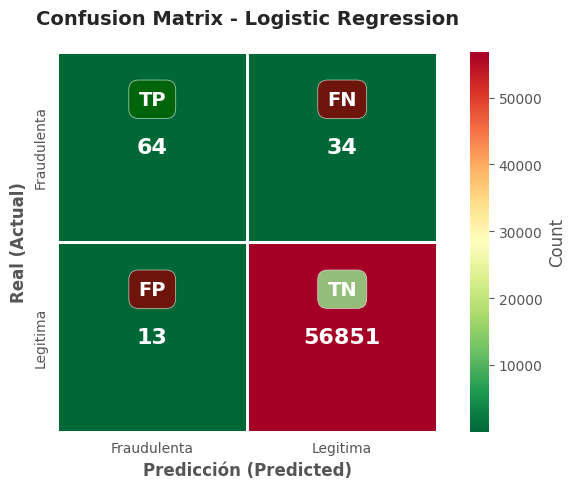

In [41]:
# Logistic Regression
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
results_lr = evaluate_model(
    model=lr_baseline,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Logistic Regression",
    show_confusion_matrix=True
)

These results show a common behavior when working with imbalanced data, where it is essential to analyze precision, recall and F1-score.

- **Precision:** Measures the proportion of correct positive predictions. It is calculated as:

    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{64}{64+13} = 0.8312
    $$

  where $TP$ are true positives and $FP$ false positives. This indicates that 83% of the transactions classified as fraudulent actually were.


- **Recall:** Measures the proportion of actual frauds detected by the model. It is calculated as:

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{64}{64+34} = 0.6531
  $$

  where $FN$ are false negatives. The model detected only 65% of actual frauds, leaving the remaining 35% undetected.
    
  In fraud detection, recall is more critical because the cost of not detecting a fraud (financial losses and reputational damage) exceeds the cost of a false alarm (additional verification). Therefore, recall should be maximized while accepting reasonable precision.


- **F1-Score:** Represents the harmonic balance between precision and recall:

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.83 \times 0.65}{0.83 + 0.65} = 0.7314
    $$

   This moderate value is insufficient for fraud detection, since it weights precision and recall similarly when recall should be prioritized.

- **Confusion matrix:** 56,851 legitimate transactions were correctly identified (99% of the test set with 56,864 total data points) and 64 fraudulent transactions. However, 34 frauds were erroneously classified as legitimate (false negatives).

    Although 34 may seem small compared to the total transactions, it is significant considering that the test set contained only 98 fraudulent cases (out of 492 in the original dataset). This represents 35% of undetected frauds, a critical proportion with serious financial implications.

----

### **2.2 NAIVE BAYES CLASSIFIER**

Next, a Naive Bayes (Gaussian) classifier will be trained without yet applying any class balancing techniques. This probabilistic model assumes independence between features and calculates the probability that a transaction is fraudulent given the observed set of features. Although this independence assumption is rarely true in real-world data, Naive Bayes often delivers surprisingly good results in classification tasks, especially when sufficient data is available.



Training Time: 0.1362 seconds


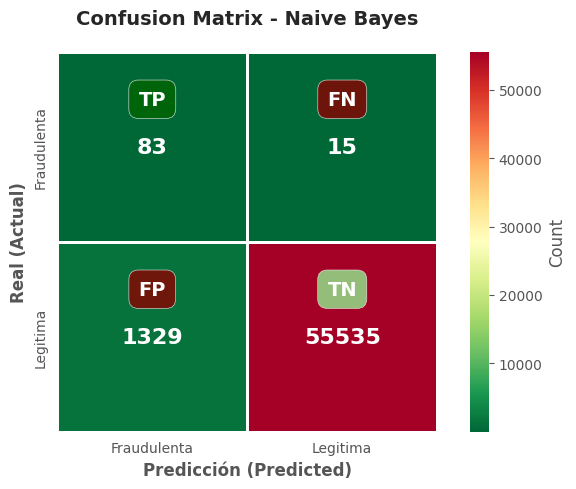

In [31]:
# Naive Bayes
nb = GaussianNB()
results_nb = evaluate_model(
    model=nb,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Naive Bayes",
    show_confusion_matrix=True
)

The results of the Naive Bayes classifier differ significantly from logistic regression, evidencing a marked trade-off between precision and recall.

- **Precision:** With barely 6%, the model correctly classifies only 1 out of every 16 transactions it identifies as fraudulent, generating 1,329 false positives.

  $$
  \text{Precision} = \frac{TP}{TP + FP} = \frac{83}{83 + 1329} = 0.0588
  $$

  In a banking context, this implies blocking approximately 16 legitimate transactions for every fraud correctly detected, resulting in a high probability of rejecting genuine customer transactions.

- **Recall:** Reaches 85%, detecting 83 of 98 actual fraudulent transactions. This represents a substantial improvement over logistic regression (65%).

  $$
  \text{Recall} = \frac{TP}{TP + FN} = \frac{83}{83 + 15} = 0.8469
  $$

  From the loss minimization perspective, this result is favorable: only 15 frauds (15%) go undetected, significantly reducing financial risk.

- **F1-Score:** At 11%, it reflects the severe imbalance between precision and recall. Although the model detects frauds effectively (high recall), it generates too many false alarms (low precision).

  $$
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.06 \times 0.85}{0.06 + 0.85} = 0.1099
  $$

  This trade-off may be acceptable if the cost of investigating false alarms is low compared to that of an undetected fraud, with the model functioning as a first filter.

- **Confusion matrix:** The model correctly identifies 55,535 legitimate transactions and detects 83 of 98 actual frauds. However, the 1,329 false positives represent an excessive amount of unnecessary alarms that would affect customer experience and banking operations.

----

### **2.3 LOGISTIC REGRESSION (BALANCED)**

A logistic regression model is used again, but this time the parameter `class_weight='balanced'` is specified. This allows the model to adjust the class weights inversely proportional to their frequencies in the training data, penalizing errors in the minority class (frauds) more heavily. The formula used for this penalization is as follows:

$$
\text{weight}_i = \frac{n_{\text{total}}}{n_{\text{classes}} \times n_i}
$$

Where $n_{\text{total}}$ is the total number of samples, $n_{\text{classes}}$ is the number of classes (2 in this case), and $n_i$ is the number of samples in class $i$. This makes the model pay more attention to fraud cases during training.


Training Time: 1.8488 seconds


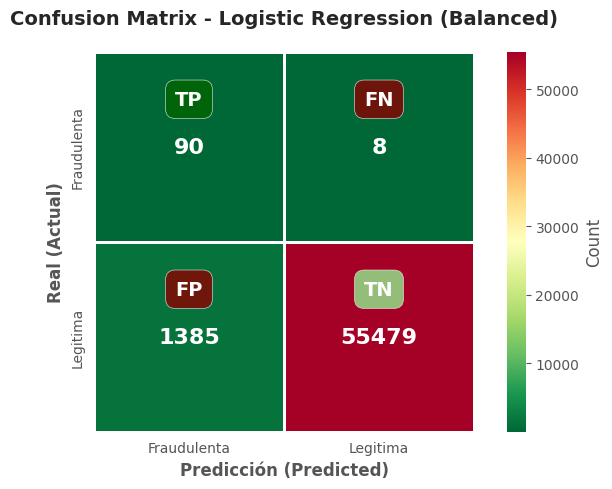

In [32]:
# LOGISTIC REGRESSION (BALANCED)
lr_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
results_lr_balanced = evaluate_model(
    model=lr_balanced,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Logistic Regression (Balanced)",
    show_confusion_matrix=True
)

These results are similar to Naive Bayes in the trade-off between precision and recall, but with an even more extreme behavior: fewer false negatives at the cost of more false positives.

- **Precision:** Reaches barely 6%, generating 1,385 false positives (legitimate transactions erroneously classified as fraud).

  $$
  \text{Precision} = \frac{TP}{TP + FP} = \frac{90}{90 + 1385} = 0.0610
  $$

- **Recall:** Increases significantly to 92%, detecting 90 of 98 actual fraudulent transactions. This represents a 30% improvement over (imbalanced) logistic regression and 7% over Naive Bayes.

  $$
  \text{Recall} = \frac{TP}{TP + FN} = \frac{90}{90 + 8} = 0.9184
  $$

  From the loss minimization perspective, only 8 frauds (8%) go undetected, considerably reducing financial risk.

- **F1-Score:** Again at 11%, it shows practically identical behavior to Naive Bayes, reflecting the same imbalance between precision and recall.

  $$
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.06 \times 0.92}{0.06 + 0.92} = 0.1144
  $$

- **Confusion matrix:** The model correctly identifies 55,478 legitimate transactions and detects 90 of 98 actual frauds. However, the 1,386 false positives generate an excessive amount of unnecessary alarms, slightly exceeding even Naive Bayes in this aspect.

----

### **2.4 LOGISTIC REGRESSION (UNDERSAMPLED)**

Random Undersampling is a data balancing technique that addresses the class imbalance problem by reducing the number of samples in the majority class to match that of the minority class.

This procedure involves first separating legitimate transactions from fraudulent ones in the training set. Then, a random subset of legitimate transactions is selected, with a size equal to the number of fraudulent transactions. In this case, there are 492 fraud cases in the entire dataset, so 492 legitimate transactions are also randomly selected. Finally, the fraudulent transactions are combined with this reduced subset of legitimate ones, thus creating a balanced 50-50 training set to train a logistic regression model and allow it to learn patterns from both classes with equal weight.

This procedure reduces bias, since in the original dataset the number of legitimate transactions significantly outnumbers the fraudulent ones. Additionally, recall tends to improve when training with balanced data; however, it is important to note that there will always be a trade-off with precision, which tends to decrease as recall increases.


Undersampled training set size: 788
Class distribution after undersampling:
Class
0    394
1    394
Name: count, dtype: int64


Training Time: 0.1081 seconds


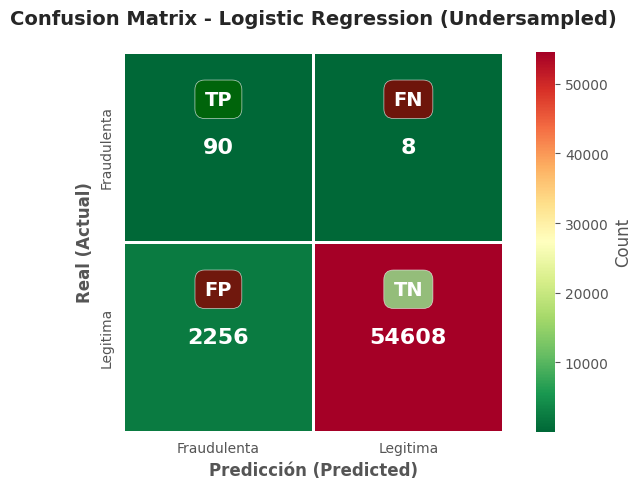

In [33]:
# Separate majority and minority classes
X_train_majority = X_train_scaled[y_train == 0]
X_train_minority = X_train_scaled[y_train == 1]
y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Undersample majority class
np.random.seed(42)
indices = np.random.choice(
    X_train_majority.index, size=len(X_train_minority), replace=False
)
X_train_majority_undersampled = X_train_majority.loc[indices]
y_train_majority_undersampled = y_train_majority.loc[indices]

# Combine minority and undersampled majority
X_train_undersampled = pd.concat([X_train_majority_undersampled, X_train_minority])
y_train_undersampled = pd.concat([y_train_majority_undersampled, y_train_minority])

print(f"\nUndersampled training set size: {len(X_train_undersampled)}")
print(f"Class distribution after undersampling:")
print(y_train_undersampled.value_counts())
print()

lr_undersampled = LogisticRegression(random_state=42, max_iter=1000)

results_lr_undersampled = evaluate_model(
    model=lr_undersampled,
    X_train=X_train_undersampled,
    y_train=y_train_undersampled,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Logistic Regression (Undersampled)",
    show_confusion_matrix=True
)

The results of the logistic regression model with Random Undersampling show a similar trend to Naive Bayes and balanced logistic regression, but more extreme: it strongly prioritizes fraud detection while generating a considerable amount of false alarms.

- **Precision:** Reaches barely 4%, showing a 62% increase in false positives compared to balanced logistic regression and 70% compared to Naive Bayes.

    $$\text{Precision} = \frac{TP}{TP + FP} = \frac{90}{90 + 2256} = 0.0384$$
    
- **Recall:** At 92%, it reaches the highest value so far, detecting 90 of 98 actual fraudulent transactions. This demonstrates the effect of undersampling in making the model more sensitive to the minority class.

    $$\text{Recall} = \frac{TP}{TP + FN} = \frac{90}{90 + 8} = 0.9184$$
    
- **F1-Score:** At 7%, it reflects the drastic imbalance between precision and recall.

    $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.04 \times 0.92}{0.04 + 0.92} = 0.0737$$
    
    This extreme trade-off suggests that undersampling, although effective in improving recall, has excessively shifted the decision threshold, making the model too conservative when classifying as fraud.
  
- **Confusion matrix:** The model correctly identifies 54,658 legitimate transactions but dramatically increases false positives to 2,206, compared to 1,329 for Naive Bayes. It detects 90 of 98 actual frauds, leaving only 8 undetected.

The random undersampling technique reduced the training set from approximately 142,405 samples to only 788 (394 of each class), creating a perfectly balanced dataset. However, this reduction eliminated valuable information from the majority class, explaining why the model over-predicts the fraudulent class. The model trained with a scenario where 50% of transactions are fraud, very different from the reality of the test set (0.17%).

Undersampling effectively improved recall, but the trade-off is not sustainable for production due to excessive false alarms. The following strategies should focus on techniques such as threshold adjustment or using `class_weight` in the model parameters.

----

### **2.5 RANDOM FOREST**

This algorithm is based on ensemble learning and combines multiple decision trees to make predictions. Initially, different subsets of data are created through **random sampling with replacement** from the training set. Each of these subsets is then used to train an independent decision tree (bagging).

At each split in every tree, only a random subset of features is considered, which introduces additional diversity among the trees and reduces the correlation that may exist between them.

Finally, a prediction is made through **voting**, where each tree in the Random Forest casts a vote for the predicted class, and the class with the highest number of votes is chosen as the model’s final prediction.


Training Time: 1 minutes and 31.43 seconds


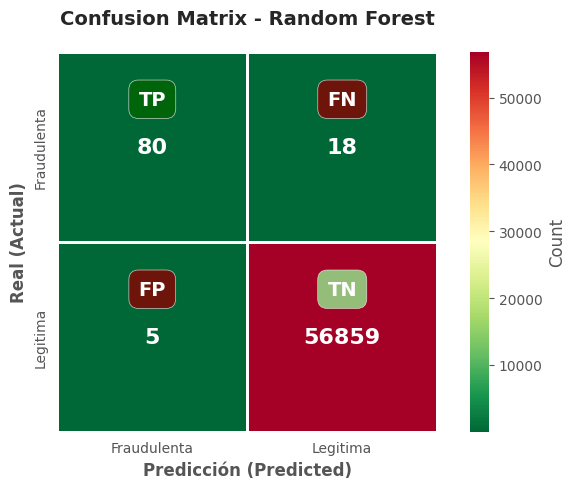

In [34]:
rf_default = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

results_rf_default = evaluate_model(
    model=rf_default,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Random Forest",
    show_confusion_matrix=True
)

These results demonstrate superior and much more balanced performance compared to previous models, achieving an optimal balance between fraud detection and minimization of false alarms.

- **Precision:** At 94%, the model shows substantial improvement. Of all transactions classified as fraudulent, 94% actually are.

  $$
  \text{Precision} = \frac{TP}{TP + FP} = \frac{80}{80 + 5} = 0.9412
  $$

  In practical terms, it generates very few false alarms (only 5 legitimate transactions erroneously classified), crucial for maintaining good user experience.

- **Recall:** At 82%, it detects the vast majority of actual fraudulent transactions (80 of 98). Although slightly lower than Naive Bayes and logistic regression with undersampling, it exceeds unbalanced logistic regression by over 26%.

  $$
  \text{Recall} = \frac{TP}{TP + FN} = \frac{80}{80 + 18} = 0.8163
  $$

  Only 18 frauds (18%) remain undetected, representing a relatively low risk level and a more realistic balance.

- **F1-Score:** At 87%, it reflects an excellent balance between precision and recall, far surpassing previous models (73% for logistic regression and 11% for Naive Bayes).

  $$
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.94 \times 0.82}{0.94 + 0.82} = 0.8743
  $$

  Random Forest simultaneously achieves detecting most frauds while maintaining a very low number of false alarms, ideal for this context.

- **Confusion matrix:** The model correctly identifies 56,859 legitimate transactions (practically 100%) and 80 fraudulent ones. False positives are drastically reduced to only 5 cases, an abysmal difference compared to balanced logistic regression and Naive Bayes. The 18 false negatives represent a middle ground between the 34 of logistic regression and the 15 of Naive Bayes.

  This balance makes Random Forest particularly effective for real-world applications, where both the cost of investigating false alarms and that of not detecting frauds must be considered. The model effectively minimizes both types of error.

Random Forest's advantages include overfitting reduction by combining multiple trees, better handling of imbalanced data compared to simpler models, insensitivity to data normalization, and ability to detect non-linear relationships between features, while also allowing evaluation of feature importance in predictions.

In [35]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_default.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
display(feature_importance.head(10))


Top 10 Most Important Features:


,feature,importance
17,V17,0.1703
14,V14,0.1364
12,V12,0.1333
10,V10,0.0741
16,V16,0.0718
11,V11,0.0453
9,V9,0.0311
4,V4,0.0305
18,V18,0.0282
7,V7,0.0246


----

### **2.6 RANDOM FOREST (BALANCED)**

In this case, a Random Forest will be trained again, with the only difference being that the parameter `class_weight='balanced'` is set in order to observe whether there is any difference compared to the previous model.


Training Time: 47.4153 seconds


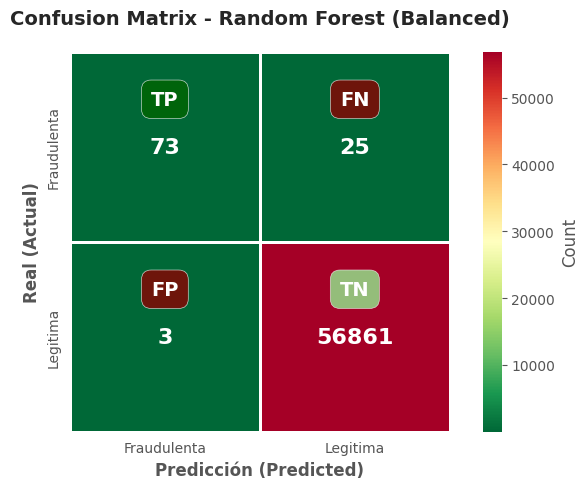

In [36]:
rf_balanced = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)

results_rf_balanced = evaluate_model(
    model=rf_balanced,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Random Forest (Balanced)",
    show_confusion_matrix=True
)

Compared to the unbalanced Random Forest, similar results are observed where the trade-off between precision and recall remains evident.

- **Precision:** The model reaches 96%, a slight improvement over the previous model, generating very few false alarms (only 3).

  $$
  \text{Precision} = \frac{TP}{TP + FP} = \frac{73}{73 + 3} = 0.9605
  $$

- **Recall:** Decreases 8% compared to the previous model, reaching 74% and increasing false negatives to 25. This represents a setback in fraud detection, where high recall should be prioritized while maintaining reasonable precision.

  $$
  \text{Recall} = \frac{TP}{TP + FN} = \frac{73}{73 + 25} = 0.7449
  $$

- **F1-Score:** At 0.83, it slightly decreases compared to the previous model (0.87), reflecting the impact of lower recall.

  $$
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.9605 \times 0.7449}{0.9605 + 0.7449} = 0.8391
  $$

  Although the model detects most frauds, the decrease in F1-score indicates lower overall effectiveness.

- **Confusion matrix:** Shows 25 false negatives, representing 25.5% of fraudulent transactions in the test set. Gaining only 2 fewer false positives (from 5 to 3) does not justify losing 7 detected frauds (from 80 to 73), making this trade-off unfavorable for fraud detection.

----

### **2.7 BAGGING - DECISION TREES**

A bagging (bootstrap aggregating) model will be used, where each model within the ensemble corresponds to a decision tree. At first glance, this approach is quite similar to a Random Forest, but the key difference is that here no random selection of feature subsets is performed.


Training Time: 5 minutes and 12.26 seconds


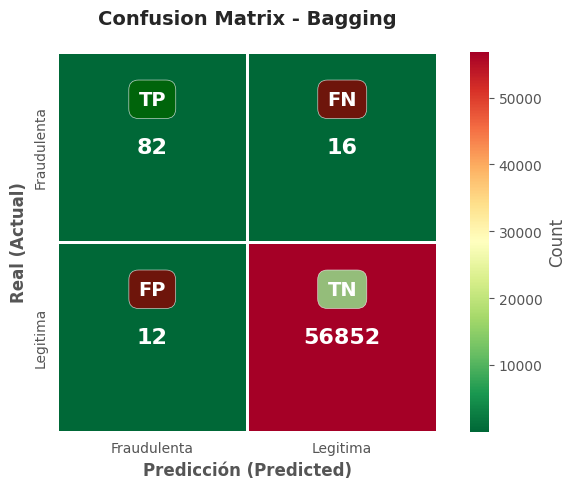

In [37]:
# Bagging
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=10, 
        min_samples_split=20,
        min_samples_leaf=10,
    ),
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)

results_bagging = evaluate_model(
    model=bagging,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Bagging",
    show_confusion_matrix=True,
)

The results of the Bagging classifier with decision trees show very solid performance, although slightly inferior to Random Forest.

- **Precision:** At 87%, it indicates that of all transactions classified as fraudulent, 87% actually are.

  $$
  \text{Precision} = \frac{TP}{TP + FP} = \frac{82}{82 + 12} = 0.8723
  $$

  Seven percentage points below Random Forest (94%). Compared to logistic regression (83%) and Naive Bayes (6%), it represents a favorable balance for verification operations.

- **Recall:** At 84%, it detects 82 of 98 actual fraudulent transactions, surpassing logistic regression (65%) and Random Forest (82%).

  $$
  \text{Recall} = \frac{TP}{TP + FN} = \frac{82}{82 + 16} = 0.8367
  $$

  Only 16 frauds (16%) go undetected, better than Random Forest (18) and significantly better than logistic regression (34), approaching Naive Bayes (85%) without sacrificing precision.

- **F1-Score:** At 0.85, it remains competitive although slightly below Random Forest (0.87).

  $$
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.87 \times 0.84}{0.87 + 0.84} = 0.8545
  $$

  This result indicates a good balance between minimizing false alarms and maximizing fraud detection.

- **Confusion matrix:** The model correctly identifies 56,852 legitimate transactions with 12 false positives, more than double that of Random Forest (5 false positives). It detects 82 of 98 frauds, leaving 16 undetected.

  The 16 undetected frauds represent 3.25% of total frauds in the original set (492 cases), an acceptable level of risk. However, the 12 false positives indicate a less optimal balance than Random Forest.

Bagging generates results very similar to Random Forest, which is expected since both algorithms perform similar procedures. However, Random Forest is more efficient and adds a layer of randomness by selecting different feature subsets for each tree, which reduces overfitting and improves precision without sacrificing recall.

----

### **2.8 GRADIENT BOOSTING (XGBOOST)**

One of the main advantages of using XGBoost is its optimization capability through gradient boosting, where each sequential tree corrects the errors of the previous ones, resulting in a highly accurate model. In addition, XGBoost incorporates regularization (L1 and L2) that helps prevent overfitting, naturally handles imbalanced data and missing values, and is computationally efficient thanks to its internal optimizations. The model also detects complex nonlinear relationships between features and provides valuable information about feature importance in predictions, which is essential for understanding which factors contribute most to fraud detection.



Training Time: 4.1692 seconds


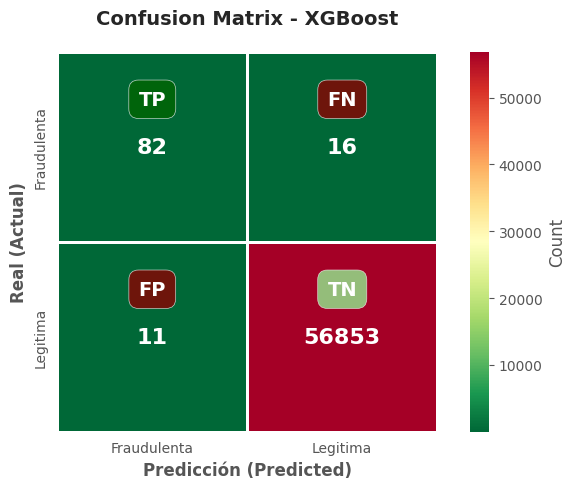

In [38]:
# XGBoost with auto-balanced weights
xgboost = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

results_xgboost = evaluate_model(
    model=xgboost,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="XGBoost",
    show_confusion_matrix=True
)

These results demonstrate exceptional performance, slightly superior to Random Forest, achieving an optimal balance between fraud detection and minimization of false alarms.

- **Precision:** At 88%, it indicates that of all transactions classified as fraudulent, 88% actually are.

  $$
  \text{Precision} = \frac{TP}{TP + FP} = \frac{82}{82 + 11} = 0.8817
  $$

  It generates few false alarms (11 legitimate transactions erroneously classified). Although 6 percentage points below Random Forest (94%), it remains excellent and represents a very low level of inconvenience for customers.

- **Recall:** At 84%, it detects 82 of 98 actual fraudulent transactions, surpassing Random Forest (82%) and approaching Naive Bayes (85%).

  $$
  \text{Recall} = \frac{TP}{TP + FN} = \frac{82}{82 + 16} = 0.8367
  $$

  Only 16 frauds (16%) go undetected, improving on Random Forest (18) and significantly better than logistic regression (34). This result offers a realistic balance with reduced risk level.

- **F1-Score:** At 86%, it practically equals Random Forest (87%) and far surpasses previous models (73% for logistic regression and 11% for Naive Bayes).

  $$
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.88 \times 0.84}{0.88 + 0.84} = 0.8592
  $$

  XGBoost simultaneously detects most frauds while maintaining a very low number of false alarms, ideal for this context.

- **Confusion matrix:** The model correctly identifies 56,853 legitimate transactions (practically 100%) and 82 fraudulent ones. The 11 false positives double those of Random Forest (5), but remain very low compared to other models. The 16 false negatives improve on Random Forest (18) and logistic regression (34).

----
----

## **3. Results Analysis**

Once all the models have been trained, comparisons are made between them based on the obtained metrics, where the most important aspects to consider are the trade-off between precision and recall, as well as the execution time of each model.

In [48]:
models = {
    "Logistic Regression": {
        "y_pred": results_lr["predictions"],
        "probabilities": results_lr["probabilities"],
        "auc": results_lr["auc_score"],
        "confusion_matrix": results_lr["confusion_matrix"],
        "time": results_lr["training_time"]
    },
    "Naive Bayes": {
        "y_pred": results_nb["predictions"],
        "probabilities": results_nb["probabilities"],
        "auc": results_nb["auc_score"],
        "confusion_matrix": results_nb["confusion_matrix"],
        "time": results_nb["training_time"]
    },
    "Logistic Regression (Balanced)": {
        "y_pred": results_lr_balanced["predictions"],
        "probabilities": results_lr_balanced["probabilities"],
        "auc": results_lr_balanced["auc_score"],
        "confusion_matrix": results_lr_balanced["confusion_matrix"],
        "time": results_lr_balanced["training_time"]
    },
    "Logistic Regression (Undersampled)": {
        "y_pred": results_lr_undersampled["predictions"],
        "probabilities": results_lr_undersampled["probabilities"],
        "auc": results_lr_undersampled["auc_score"],
        "confusion_matrix": results_lr_undersampled["confusion_matrix"],
        "time": results_lr_undersampled["training_time"]
    },
    "Random Forest": {
        "y_pred": results_rf_default["predictions"],
        "probabilities": results_rf_default["probabilities"],
        "auc": results_rf_default["auc_score"],
        "confusion_matrix": results_rf_default["confusion_matrix"],
        "time": results_rf_default["training_time"]
    },
    "Random Forest (Balanced)": {
        "y_pred": results_rf_balanced["predictions"],
        "probabilities": results_rf_balanced["probabilities"],
        "auc": results_rf_balanced["auc_score"],
        "confusion_matrix": results_rf_balanced["confusion_matrix"],
        "time": results_rf_balanced["training_time"]
    },
    "Bagging Classifier": {
        "y_pred": results_bagging["predictions"],
        "probabilities": results_bagging["probabilities"],
        "auc": results_bagging["auc_score"],
        "confusion_matrix": results_bagging["confusion_matrix"],
        "time": results_bagging["training_time"]
    },
    "Gradient Boosting": {
        "y_pred": results_xgboost["predictions"],
        "probabilities": results_xgboost["probabilities"],
        "auc": results_xgboost["auc_score"],
        "confusion_matrix": results_xgboost["confusion_matrix"],
        "time": results_xgboost["training_time"]
    },
}


# Calculate metrics for all models
results_df = []
for name, result in models.items():
    precision = precision_score(y_test, result["y_pred"])
    recall = recall_score(y_test, result["y_pred"])
    f1 = f1_score(y_test, result["y_pred"])

    results_df.append(
        {
            "Model": name,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Training Time": result["time"],
            "ROC-AUC": result["auc"]
        }
    )

results_df = pd.DataFrame(results_df)
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
display(results_df)


MODEL COMPARISON SUMMARY


,Model,Precision,Recall,F1-Score,Training Time,ROC-AUC
0,Logistic Regression,0.8312,0.6531,0.7314,2.4257,0.9560
1,Naive Bayes,0.0588,0.8469,0.1099,0.1362,0.9632
2,Logistic Regression (Balanced),0.0610,0.9184,0.1144,1.8488,0.9721
3,Logistic Regression (Undersampled),0.0384,0.9184,0.0736,0.1081,0.9762
4,Random Forest,0.9412,0.8163,0.8743,91.4341,0.9630
5,Random Forest (Balanced),0.9605,0.7449,0.8391,47.4153,0.9529
6,Bagging Classifier,0.8723,0.8367,0.8542,312.2567,0.9740
7,Gradient Boosting,0.8817,0.8367,0.8586,4.1692,0.9684


Based on the metrics obtained, four main candidates can be identified as strong performers for fraud detection:

- **Gradient Boosting** emerges as the optimal model, achieving the best overall balance with an F1-score of 0.8586. It maintains strong precision (0.8817) and recall (0.8367), effectively identifying fraudulent transactions while minimizing false positives. The model also demonstrates excellent discriminative ability with a ROC-AUC of 0.9684 and remarkable efficiency with a training time of just 5.5 seconds, making it highly suitable for production environments.

- **Bagging Classifier** delivers competitive performance with an F1-score of 0.8542 and precision/recall metrics nearly equivalent to Gradient Boosting. Notably, it achieves the highest ROC-AUC (0.9740) among ensemble methods, indicating superior capability in distinguishing fraudulent from legitimate transactions. The primary limitation is its extended training time of approximately 355 seconds, which may present challenges in scenarios requiring frequent model updates.

- **Random Forest** stands out for its exceptional precision (0.9412), the highest across all evaluated models. This makes it particularly valuable in contexts where false positive reduction is critical. While maintaining a solid F1-score of 0.8743, the recall decreases slightly to 0.8163. The training time of ~106 seconds remains within acceptable bounds for most practical applications.

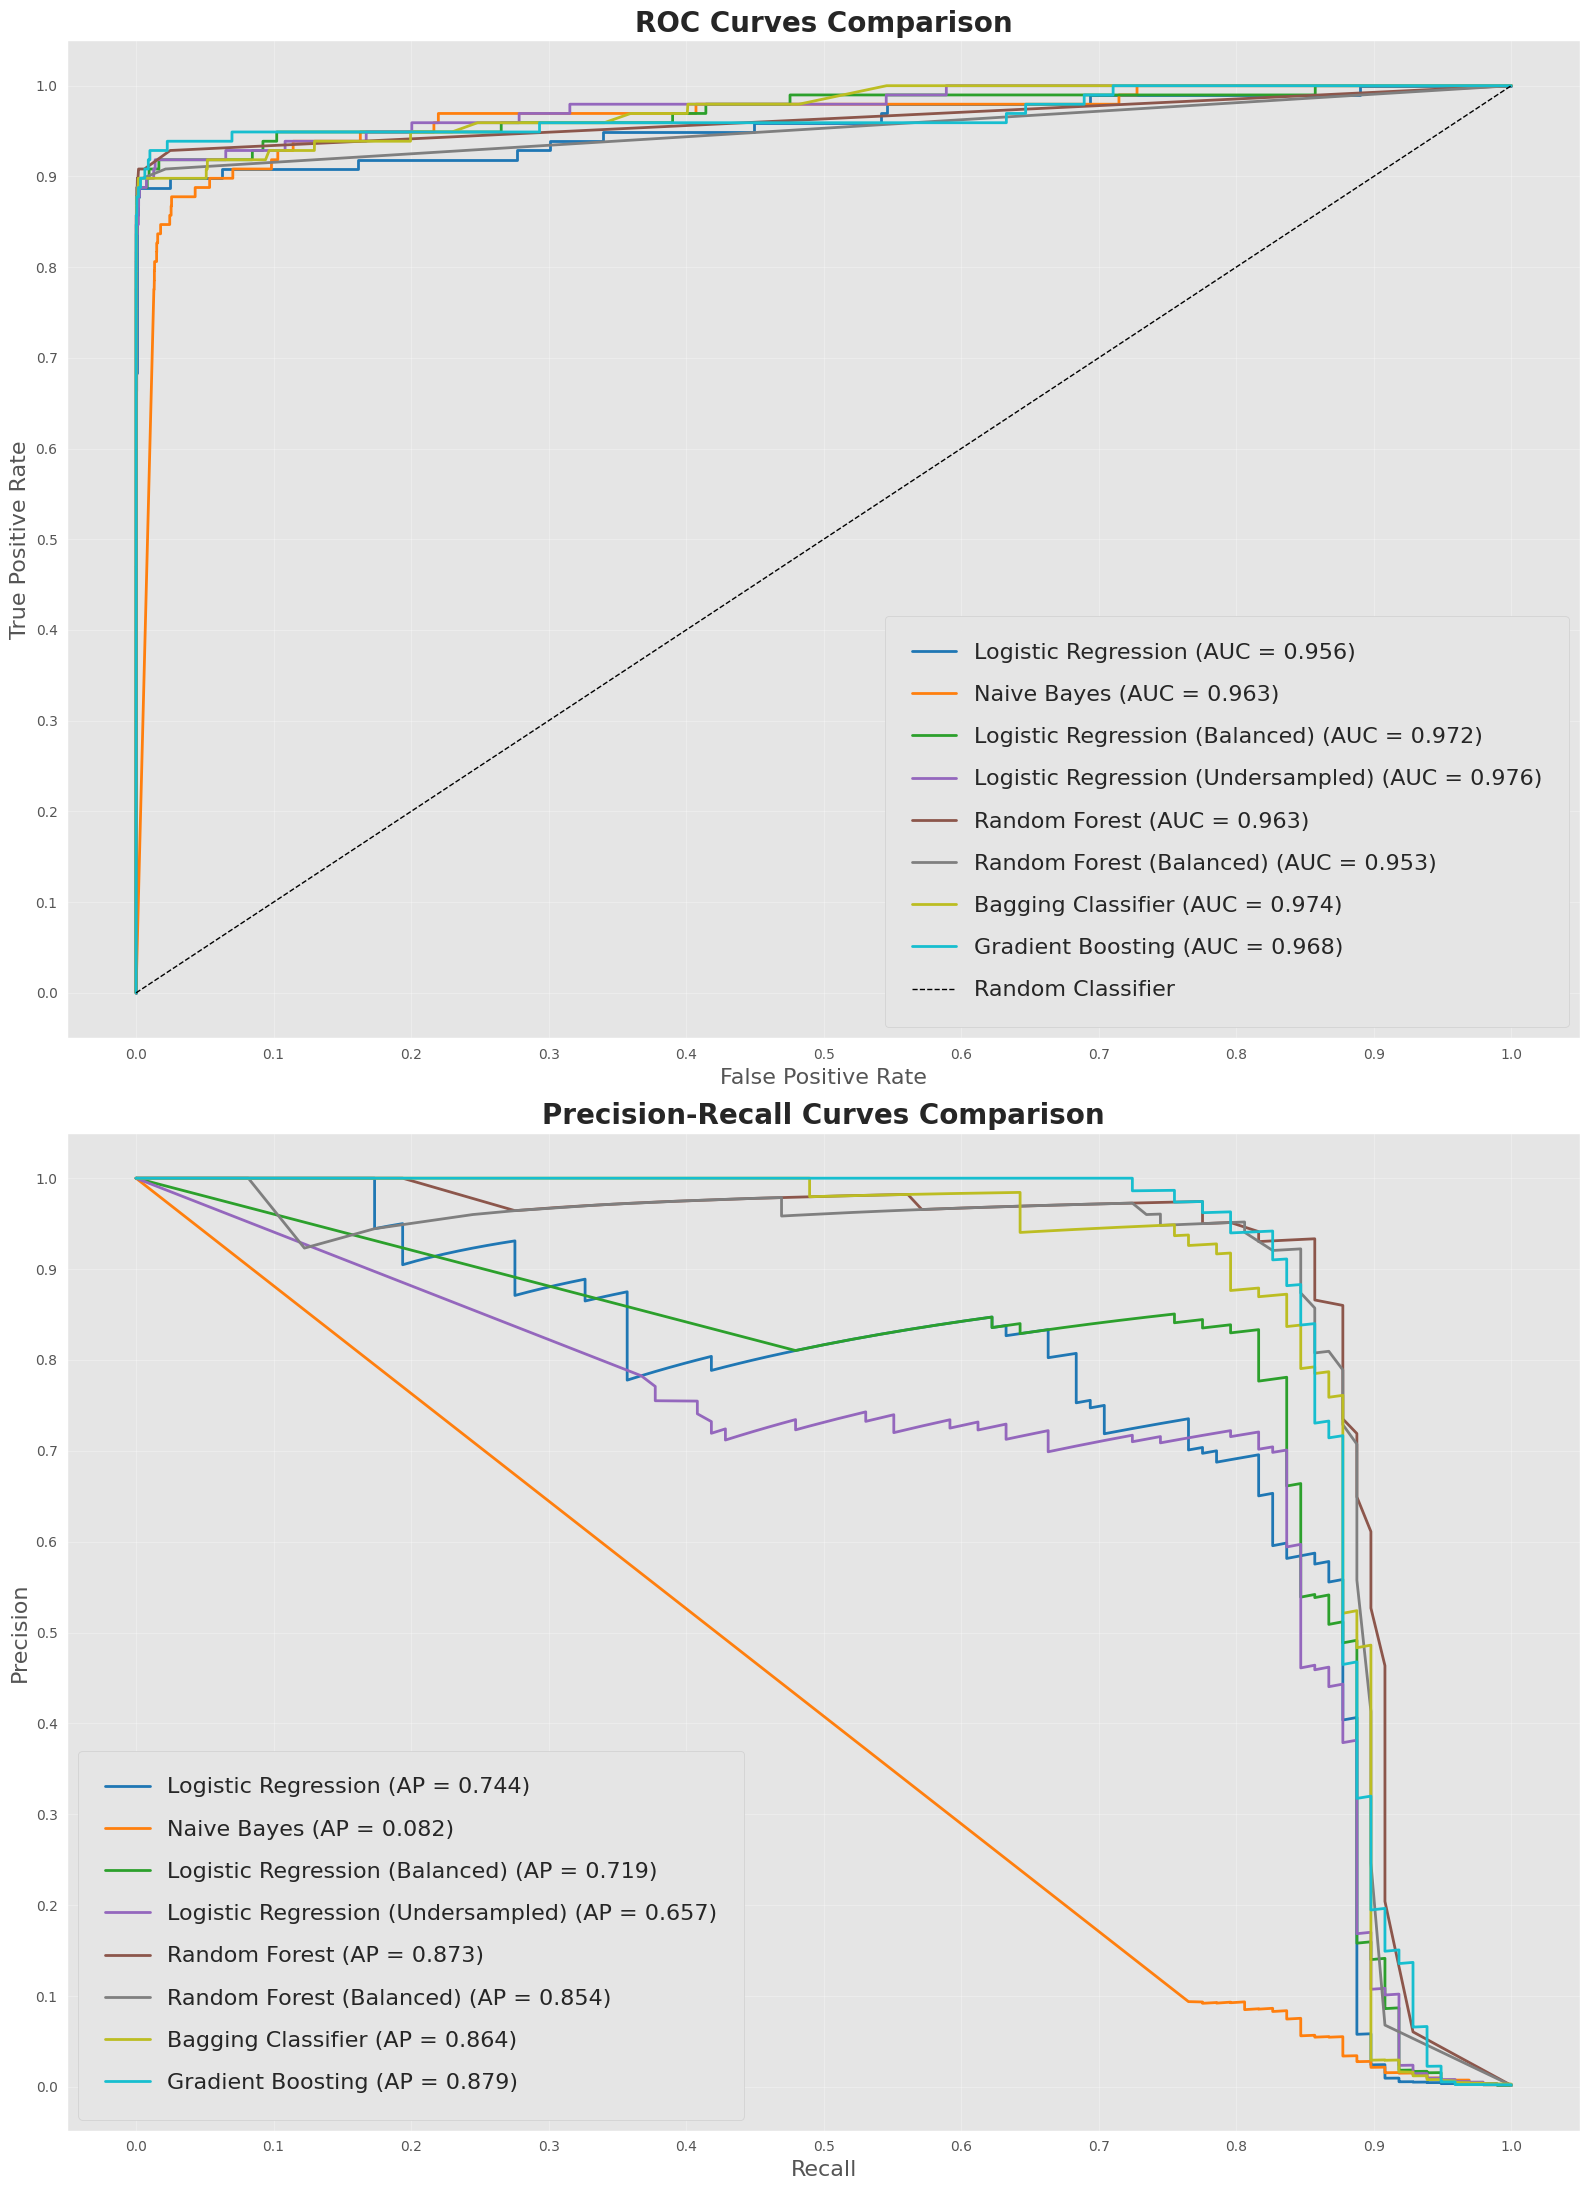

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

colors = cm.get_cmap('tab10', len(models))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 22))

# ROC Curves
for i, (name, result) in enumerate(models.items()):
    fpr, tpr, _ = roc_curve(y_test, result["probabilities"])
    ax1.plot(fpr, tpr, color=colors(i),
             label=f"{name} (AUC = {result['auc']:.3f})", linewidth=2)

ax1.plot([0, 1], [0, 1], "k--", label="Random Classifier", linewidth=1)
ax1.set_xlabel("False Positive Rate", fontsize=16)
ax1.set_ylabel("True Positive Rate", fontsize=16)
ax1.set_title("ROC Curves Comparison", fontsize=20, fontweight="bold")
ax1.legend(
    loc="lower right",
    fontsize=16,
    markerscale=1.5,
    frameon=True,
    framealpha=0.9,
    borderpad=1.2,
    labelspacing=1.0
)
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
for i, (name, result) in enumerate(models.items()):
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['probabilities'])
    avg_precision = average_precision_score(y_test, result['probabilities'])
    ax2.plot(recall_curve, precision_curve, color=colors(i),
             label=f"{name} (AP = {avg_precision:.3f})", linewidth=2)

# Tick adjustments
ax1.set_xticks(np.linspace(0, 1, 11))  
ax2.set_xticks(np.linspace(0, 1, 11))  
ax1.set_yticks(np.linspace(0, 1, 11))  
ax2.set_yticks(np.linspace(0, 1, 11)) 

ax2.set_xlabel('Recall', fontsize=16)
ax2.set_ylabel('Precision', fontsize=16)
ax2.set_title('Precision-Recall Curves Comparison', fontsize=20, fontweight='bold')
ax2.legend(
    loc='lower left',
    fontsize=16,
    markerscale=1.5,
    frameon=True,
    framealpha=0.9,
    borderpad=1.2,
    labelspacing=1.0
)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#### **Precision-Recall Curves**

The Precision-Recall curve visualizes the trade-off between precision and recall across different classification thresholds. Each point on the curve represents a different decision threshold, showing how many frauds can be detected (recall) versus how many false alarms are generated (1 - precision). The **Average Precision (AP)** score summarizes the curve's quality, with higher values indicating better overall performance.

The models cluster into three distinct performance tiers based on their Average Precision scores. The top-performing group includes Gradient Boosting (AP = 0.879), Random Forest (AP = 0.873), Bagging Classifier (AP = 0.864), and Random Forest Balanced (AP = 0.854). These models demonstrate curves that remain in the upper-right region of the plot, maintaining high precision even as recall increases. This behavior indicates they can detect a large proportion of frauds without generating excessive false positives, making them operationally viable across different threshold settings.

The middle-tier group consists of standard Logistic Regression (AP = 0.744) and Logistic Regression Balanced (AP = 0.719), which show moderate performance with steeper precision drops as recall increases. Finally, the lower-performing group includes Logistic Regression Undersampled (AP = 0.657) and notably Naive Bayes (AP = 0.082), whose curve collapses dramatically. The Naive Bayes curve reveals its fundamental limitation: it can achieve high recall only by accepting extremely low precision, as evidenced by the steep diagonal descent from high to low precision values.

The shape of each curve tells us about model robustness. Models with curves that remain near the top-right corner across a wide recall range (like Random Forest and XGBoost) offer flexibility in threshold selection. Operational parameters can be adjusted without dramatic performance degradation. In contrast, models whose curves drop sharply (like Naive Bayes) provide little operational flexibility: any attempt to increase recall results in catastrophic precision loss.

The area under the PR curve (Average Precision) is particularly informative for imbalanced datasets like fraud detection. Unlike accuracy, which can be misleadingly high when most transactions are legitimate, the AP value focuses specifically on how well the model handles the minority (fraud) class. The 79-88% AP scores of the top models indicate they successfully learned to identify fraud patterns rather than simply predicting the majority class.

#### **ROC Curves**

The ROC curve plots the True Positive Rate (recall) against the False Positive Rate across all thresholds, with the Area Under the Curve (AUC-ROC) measuring overall discrimination ability. An AUC of 1.0 represents perfect discrimination, while 0.5 indicates random guessing (the diagonal dashed line).

All models demonstrate excellent discrimination ability, with AUC-ROC scores ranging from 0.953 to 0.976. The curves cluster tightly in the upper-left region, indicating that all models can effectively distinguish between fraudulent and legitimate transactions when evaluated purely on their ranking ability. The top performers are Bagging Classifier (AUC = 0.974), Logistic Regression Undersampled (AUC = 0.976), and Logistic Regression Balanced (AUC = 0.972), followed closely by Gradient Boosting (AUC = 0.968) and Naive Bayes (AUC = 0.963).

An interesting discrepancy emerges when comparing ROC and PR curve rankings. Naive Bayes achieves a strong ROC-AUC (0.963) but the worst Average Precision (0.082). Similarly, Logistic Regression Undersampled has the second-best ROC-AUC (0.976) but mediocre Average Precision (0.657). This apparent contradiction reveals a critical insight about metric selection for imbalanced datasets.

ROC curves can be overly optimistic for imbalanced datasets because they incorporate True Negative Rate (specificity) in their calculation. With 99.8% of transactions being legitimate, achieving high True Negative Rates is relatively easy (a model can score well on ROC simply by correctly classifying the abundant negative class). The PR curve, however, focuses exclusively on positive predictions and thus provides a more realistic assessment when the positive class (fraud) is rare.

This explains why Naive Bayes appears reasonable on the ROC curve but performs poorly in practice: it correctly ranks most transactions (good ROC-AUC) but generates an unacceptable number of false positives when actually making predictions (poor Average Precision). The model's probability calibration is severely distorted, causing it to classify far too many transactions as fraudulent despite maintaining reasonable ranking ability.

For fraud detection deployment, Precision-Recall curves are more informative than ROC curves because they directly reflect operational concerns: how many frauds can we catch (recall) versus how many legitimate transactions we'll mistakenly block (precision). The PR curve analysis confirms that Random Forest, Gradient Boosting, and Bagging Classifier are the most production-ready models, as they maintain strong performance across the metrics that matter most in an imbalanced, high-stakes environment.

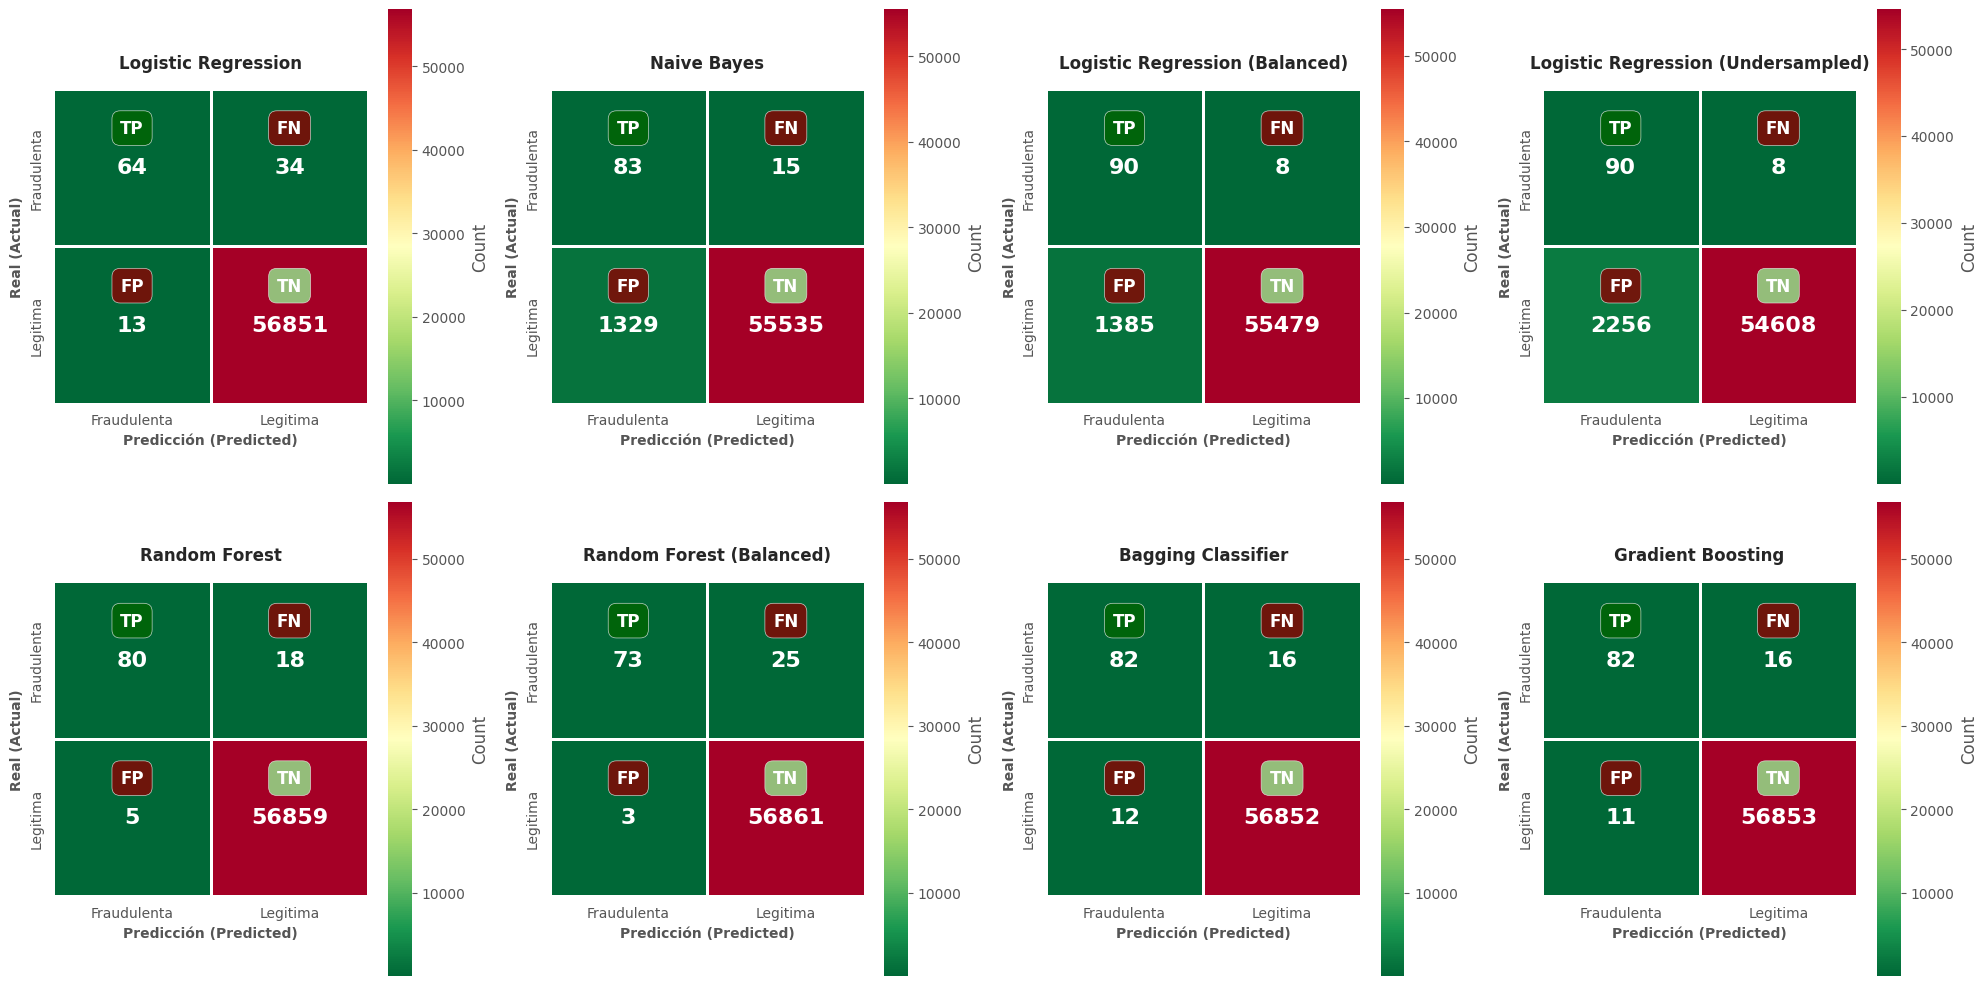

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, (name, result) in enumerate(models.items()):
    cm = result['confusion_matrix']
    
    # Create heatmap with enhanced styling
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='RdYlGn_r',
        xticklabels=['Fraudulenta', 'Legitima'],
        yticklabels=['Fraudulenta', 'Legitima'],
        cbar_kws={'label': 'Count'},
        linewidths=2,
        linecolor='white',
        square=True,
        annot_kws={'size': 16, 'weight': 'bold'},
        ax=axes[idx]
    )
    
    # Set title and labels
    axes[idx].set_title(f'{name}', fontweight='bold', fontsize=12, pad=15)
    axes[idx].set_ylabel('Real (Actual)', fontweight='bold', fontsize=10)
    axes[idx].set_xlabel('Predicción (Predicted)', fontweight='bold', fontsize=10)
    
    axes[idx].text(
        0.5, 0.25, 'TP',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='darkgreen', alpha=0.8)
    )
    axes[idx].text(
        1.5, 0.25, 'FN',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='darkred', alpha=0.8)
    )
    axes[idx].text(
        0.5, 1.25, 'FP',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='darkred', alpha=0.8)
    )
    axes[idx].text(
        1.5, 1.25, 'TN',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8)
    )

for idx in range(len(models), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

----
----

## **4. Cost Analysis**

In real-world scenarios, not all errors have the same economic impact. This is especially true in fraud detection, where the cost of failing to identify a fraudulent transaction can be much higher than the cost of incorrectly flagging a legitimate one. However, having too many false positives is also undesirable, as it can cause inconvenience for customers and increase operational expenses.

This asymmetry in costs should be considered during model evaluation. One way to capture it is by using the **F-β score**, which allows adjusting the relative importance of precision and recall. The formula is defined as:

$$
F_{\beta} = (1 + \beta^2) \cdot \frac{\text{Precision} \times \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}
$$

Here, $\beta$ is a positive real number that controls the trade-off between precision and recall:

- When $\beta < 1$, the score gives more weight to **precision**, penalizing false positives more heavily.  
- When $\beta > 1$, the score emphasizes **recall**, giving greater importance to detecting fraudulent transactions.  

In the context of fraud detection, where missing a fraud can be far more costly than a false alarm, it is common to select a $\beta$ value greater than 1 (for example, $\beta = 2$) to prioritize recall while still considering precision.


In [51]:
from sklearn.metrics import fbeta_score

fbeta_results = []
beta_values = [0.5, 1.0, 2.0, 3.0]  

for name, result in models.items():
    row = {"Model": name}
    for beta in beta_values:
        fb_score = fbeta_score(y_test, result["y_pred"], beta=beta)
        row[f"F{beta}-Score"] = fb_score
    fbeta_results.append(row)

fbeta_df = pd.DataFrame(fbeta_results)

print("\n" + "=" * 80)
print("F-BETA SCORE COMPARISON")
print("=" * 80)
print("\nInterpretation:")
print("  - F0.5: Favors precision (minimizes false positives)")
print("  - F1.0: Standard balance between precision and recall")
print("  - F2.0: Favors recall 2x more (common in fraud detection)")
print("  - F3.0: Favors recall 3x more (high-risk contexts)\n")
display(fbeta_df)


F-BETA SCORE COMPARISON

Interpretation:
  - F0.5: Favors precision (minimizes false positives)
  - F1.0: Standard balance between precision and recall
  - F2.0: Favors recall 2x more (common in fraud detection)
  - F3.0: Favors recall 3x more (high-risk contexts)



,Model,F0.5-Score,F1.0-Score,F2.0-Score,F3.0-Score
0,Logistic Regression,0.7882,0.7314,0.6823,0.6674
1,Naive Bayes,0.0722,0.1099,0.2300,0.3618
2,Logistic Regression (Balanced),0.0750,0.1144,0.2410,0.3818
3,Logistic Regression (Undersampled),0.0475,0.0736,0.1644,0.2788
4,Random Forest,0.9132,0.8743,0.8386,0.8273
5,Random Forest (Balanced),0.9080,0.8391,0.7799,0.7620
6,Bagging Classifier,0.8650,0.8542,0.8436,0.8402
7,Gradient Boosting,0.8723,0.8586,0.8454,0.8410


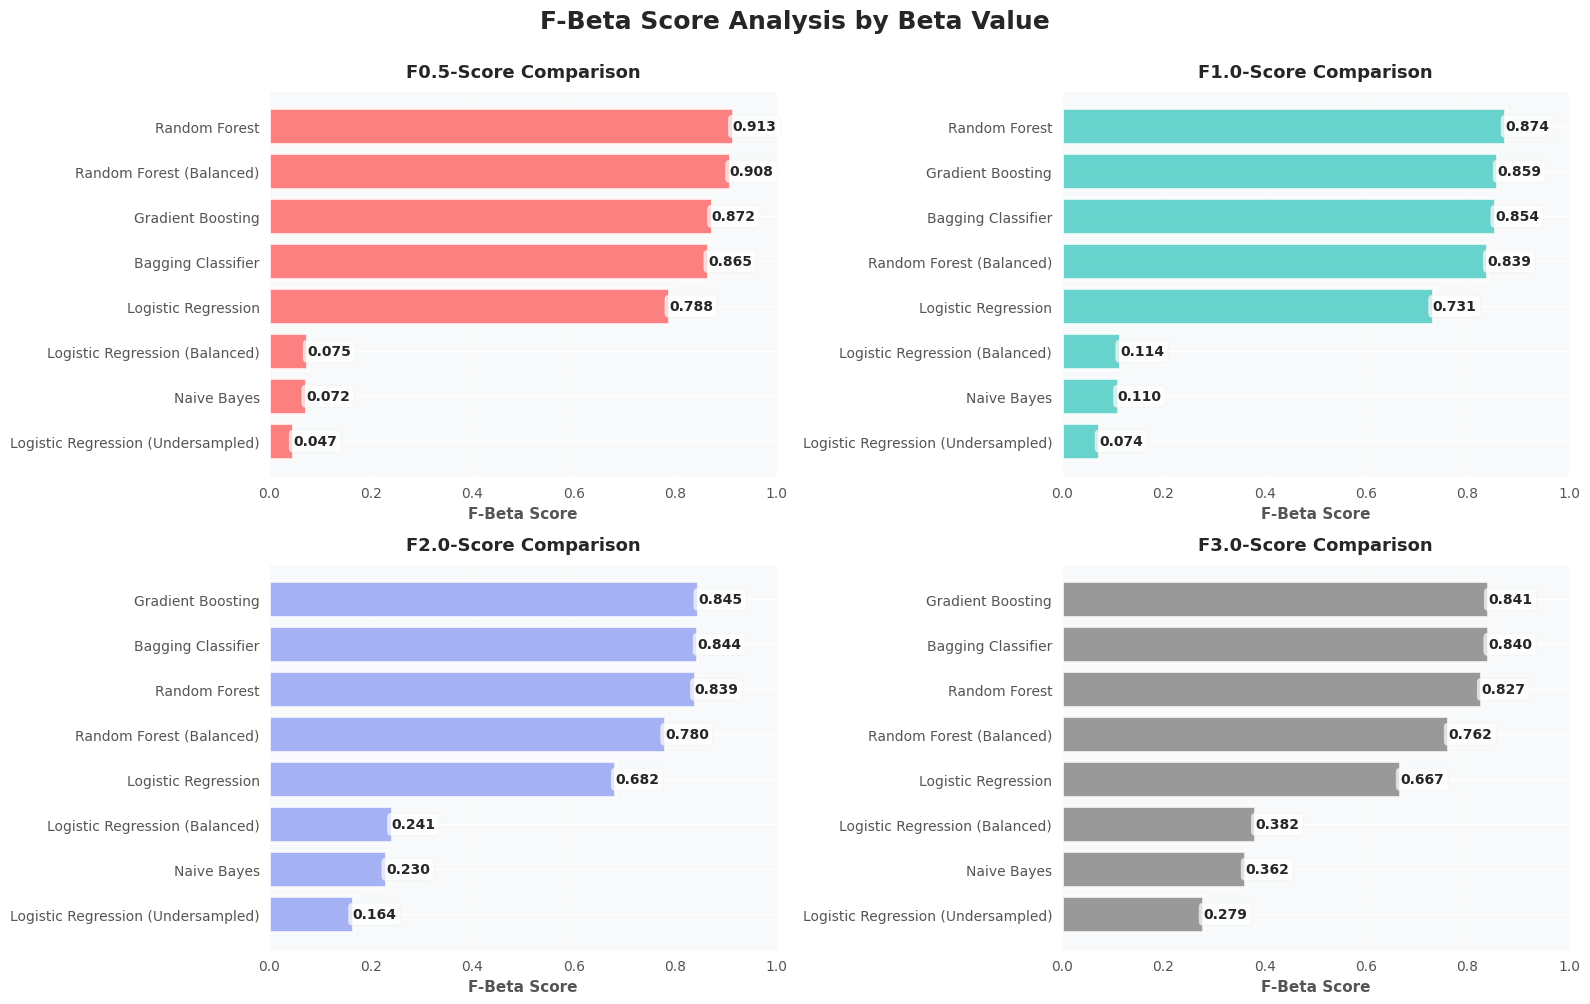

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#95A5F3', '#888888']

for idx, beta in enumerate(beta_values):
    ax = axes[idx]
    sorted_df = fbeta_df.sort_values(by=f'F{beta}-Score', ascending=True)
    
    bars = ax.barh(sorted_df['Model'], sorted_df[f'F{beta}-Score'], 
                   color=colors[idx], alpha=0.85, edgecolor='white', linewidth=2)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('F-Beta Score', fontsize=11, fontweight='bold')
    ax.set_title(f'F{beta}-Score Comparison', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlim(0, 1.0)
    ax.grid(True, alpha=0.2, axis='x', linestyle='--')
    ax.set_facecolor('#f8f9fa')

plt.suptitle('F-Beta Score Analysis by Beta Value', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("fbeta_small_multiples.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

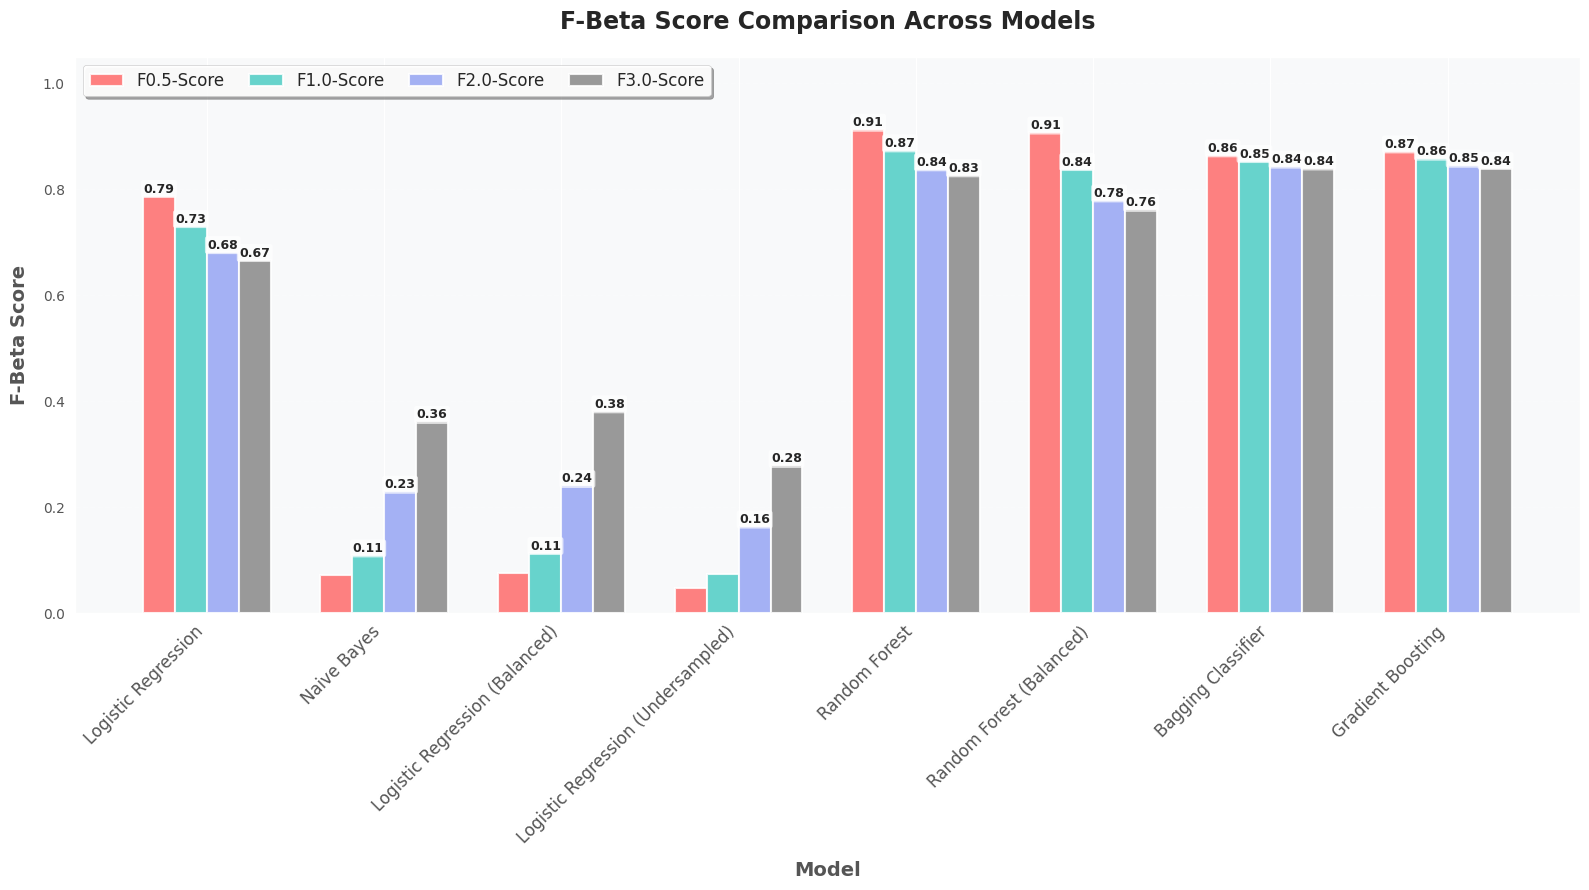

In [53]:
fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(len(fbeta_df))
width = 0.18
colors = ['#FF6B6B', '#4ECDC4', '#95A5F3', '#888888']

# Create bars with better styling
bars_list = []
for i, beta in enumerate(beta_values):
    offset = width * (i - 1.5)
    bars = ax.bar(
        x + offset, 
        fbeta_df[f"F{beta}-Score"], 
        width, 
        label=f"F{beta}-Score",
        alpha=0.85,
        color=colors[i],
        edgecolor='white',
        linewidth=1.5
    )
    bars_list.append(bars)
    
    # Add value labels on top of bars (only if visible)
    for bar in bars:
        height = bar.get_height()
        if height > 0.08:  # Only show label if bar is reasonably visible
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                            alpha=0.7, edgecolor='none'))

# Styling
ax.set_xlabel("Model", fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel("F-Beta Score", fontsize=14, fontweight='bold', labelpad=10)
ax.set_title("F-Beta Score Comparison Across Models", 
             fontsize=17, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(fbeta_df["Model"], rotation=45, ha="right", fontsize=12)
ax.set_ylim(0, 1.05)

# Enhanced legend
legend = ax.legend(fontsize=12, frameon=True, shadow=True, 
                   loc='upper left', ncol=4, columnspacing=1.5)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.95)

# Grid and background
ax.grid(True, alpha=0.25, axis="y", linestyle='--', linewidth=1)
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig("fbeta_grouped_comparison.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

In [54]:
# PLOTTING FUNCTIONS

def plot_continuous_fbeta(model_name, y_true, y_pred, beta_range=(0.1, 5.0), num_points=100, 
                          save_fig=False, filename=None, show_metrics=True):
    """
    Plot continuous F-beta score curve for a given model.
    
    Parameters:
    -----------
    model_name : str
        Name of the model for the plot title
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    beta_range : tuple
        Range of beta values to plot (min, max)
    num_points : int
        Number of points to calculate in the beta range
    save_fig : bool
        Whether to save the figure
    filename : str
        Filename to save (if save_fig=True)
    show_metrics : bool
        Whether to show precision and recall on the plot
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    beta_scores : dict with beta values and corresponding f-beta scores
    """
    
    # Generate beta values
    beta_values = np.linspace(beta_range[0], beta_range[1], num_points)
    
    # Calculate F-beta scores for each beta
    fbeta_scores = []
    for beta in beta_values:
        score = fbeta_score(y_true, y_pred, beta=beta, zero_division=0)
        fbeta_scores.append(score)
    
    # Calculate precision and recall (constant for a given model)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot the continuous curve
    ax.plot(beta_values, fbeta_scores, linewidth=3, color='#2E86AB', 
            label=f'{model_name}', alpha=0.9)
    
    # Fill area under curve
    ax.fill_between(beta_values, fbeta_scores, alpha=0.2, color='#2E86AB')
    
    # Mark special beta values
    special_betas = [0.5, 1.0, 2.0, 3.0]
    special_scores = [fbeta_score(y_true, y_pred, beta=b, zero_division=0) 
                      for b in special_betas]
    
    ax.scatter(special_betas, special_scores, s=150, c='red', zorder=5, 
              edgecolors='white', linewidth=2, label='Standard β values')
    
    # Add value labels for special betas
    for beta, score in zip(special_betas, special_scores):
        ax.annotate(f'F{beta}: {score:.3f}', 
                   xy=(beta, score), 
                   xytext=(0, 15),
                   textcoords='offset points',
                   ha='center',
                   fontsize=10,
                   fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                            alpha=0.7, edgecolor='none'))
    
    # Add horizontal lines for precision and recall
    if show_metrics:
        ax.axhline(y=precision, color='#27ae60', linestyle='--', linewidth=2, 
                  alpha=0.7, label=f'Precision = {precision:.3f}')
        ax.axhline(y=recall, color='#e74c3c', linestyle='--', linewidth=2, 
                  alpha=0.7, label=f'Recall = {recall:.3f}')
        
        # Add shaded regions to show convergence
        ax.axvspan(beta_range[0], 0.2, alpha=0.1, color='green', 
                  label='Precision-dominant region')
        ax.axvspan(4.0, beta_range[1], alpha=0.1, color='red', 
                  label='Recall-dominant region')
    
    # Calculate and display stability metrics
    beta_std = np.std(fbeta_scores)
    beta_range_val = max(fbeta_scores) - min(fbeta_scores)
    
    stability_text = (f'Stability Metrics:\n'
                     f'Range: {beta_range_val:.3f}\n'
                     f'Std Dev: {beta_std:.3f}\n'
                     f'Precision: {precision:.3f}\n'
                     f'Recall: {recall:.3f}')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.02, stability_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=props, family='monospace')
    
    # Styling
    ax.set_xlabel('Beta Value (β)', fontsize=13, fontweight='bold')
    ax.set_ylabel('F-Beta Score', fontsize=13, fontweight='bold')
    ax.set_title(f'Continuous F-Beta Score Analysis: {model_name}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlim(beta_range[0], beta_range[1])
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, frameon=True, shadow=True, loc='best')
    ax.set_facecolor('#f8f9fa')
    
    # Add interpretation annotations
    ax.text(0.3, 0.95, 'β → 0: Favors Precision', transform=ax.transAxes,
           fontsize=10, style='italic', alpha=0.7,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.3))
    
    ax.text(0.7, 0.95, 'β → ∞: Favors Recall', transform=ax.transAxes,
           fontsize=10, style='italic', alpha=0.7,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.3))
    
    plt.tight_layout()
    
    # Save if requested
    if save_fig:
        if filename is None:
            filename = f"fbeta_continuous_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved as: {filename}")
    
    plt.show()
    
    # Return results
    beta_scores = {
        'beta_values': beta_values,
        'fbeta_scores': fbeta_scores,
        'precision': precision,
        'recall': recall,
        'stability_range': beta_range_val,
        'stability_std': beta_std
    }
    
    return fig, ax, beta_scores


def plot_continuous_fbeta_comparison(models_dict, beta_range=(0.1, 5.0), num_points=100,
                                    save_fig=False, filename='fbeta_comparison.png'):
    """
    Plot continuous F-beta curves for multiple models in one figure.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with structure: {model_name: {'y_true': array, 'y_pred': array}}
    beta_range : tuple
        Range of beta values to plot
    num_points : int
        Number of points to calculate
    save_fig : bool
        Whether to save the figure
    filename : str
        Filename to save
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    all_results : dict with results for each model
    """
    
    # Generate beta values
    beta_values = np.linspace(beta_range[0], beta_range[1], num_points)
    
    # Color palette for different models
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', 
              '#6A994E', '#BC4B51', '#8B5A3C', '#5E548E']
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    all_results = {}
    
    for idx, (model_name, data) in enumerate(models_dict.items()):
        y_true = data['y_true']
        y_pred = data['y_pred']
        
        # Calculate F-beta scores
        fbeta_scores = [fbeta_score(y_true, y_pred, beta=b, zero_division=0) 
                       for b in beta_values]
        
        # Calculate metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        
        # Determine line style based on stability
        beta_range_val = max(fbeta_scores) - min(fbeta_scores)
        linestyle = '-' if abs(beta_range_val) < 0.15 else '--'
        linewidth = 2.5 if abs(beta_range_val) < 0.15 else 2
        alpha = 0.9 if abs(beta_range_val) < 0.15 else 0.6
        
        # Plot the curve
        ax.plot(beta_values, fbeta_scores, linewidth=linewidth, 
               color=colors[idx % len(colors)], label=model_name, 
               linestyle=linestyle, alpha=alpha)
        
        # Store results
        all_results[model_name] = {
            'beta_values': beta_values,
            'fbeta_scores': fbeta_scores,
            'precision': precision,
            'recall': recall,
            'stability_range': beta_range_val,
            'stability_std': np.std(fbeta_scores)
        }
    
    # Mark special beta values
    for beta in [0.5, 1.0, 2.0, 3.0]:
        ax.axvline(x=beta, color='gray', linestyle=':', alpha=0.3, linewidth=1)
        ax.text(beta, 1.02, f'β={beta}', ha='center', fontsize=9, 
               fontweight='bold', color='gray')
    
    # Styling
    ax.set_xlabel('Beta Value (β)', fontsize=14, fontweight='bold')
    ax.set_ylabel('F-Beta Score', fontsize=14, fontweight='bold')
    ax.set_title('Continuous F-Beta Score Comparison Across Models', 
                fontsize=17, fontweight='bold', pad=20)
    ax.set_xlim(beta_range[0], beta_range[1])
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=11, frameon=True, shadow=True, loc='best', ncol=2)
    ax.set_facecolor('#f8f9fa')
    
    # Add interpretation
    interpretation = ('Solid lines: Stable models (|Range| < 0.15)\n'
                     'Dashed lines: Unstable models (|Range| ≥ 0.15)')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.02, 0.98, interpretation, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved as: {filename}")
    
    plt.show()
    
    return fig, ax, all_results


def plot_continuous_fbeta_grid(models_dict, beta_range=(0.1, 5.0), num_points=100,
                              save_fig=False, filename='fbeta_grid.png'):
    """
    Create a grid of continuous F-beta plots, one for each model.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with structure: {model_name: {'y_true': array, 'y_pred': array}}
    beta_range : tuple
        Range of beta values
    num_points : int
        Number of points
    save_fig : bool
        Whether to save
    filename : str
        Filename
    """
    
    n_models = len(models_dict)
    n_cols = 2
    n_rows = int(np.ceil(n_models / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    beta_values = np.linspace(beta_range[0], beta_range[1], num_points)
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', 
              '#6A994E', '#BC4B51', '#8B5A3C', '#5E548E']
    
    for idx, (model_name, data) in enumerate(models_dict.items()):
        ax = axes[idx]
        y_true = data['y_true']
        y_pred = data['y_pred']
        
        # Calculate scores
        fbeta_scores = [fbeta_score(y_true, y_pred, beta=b, zero_division=0) 
                       for b in beta_values]
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        
        # Plot
        ax.plot(beta_values, fbeta_scores, linewidth=3, 
               color=colors[idx % len(colors)], alpha=0.9)
        ax.fill_between(beta_values, fbeta_scores, alpha=0.2, 
                       color=colors[idx % len(colors)])
        
        # Add precision and recall lines
        ax.axhline(y=precision, color='#27ae60', linestyle='--', 
                  linewidth=2, alpha=0.6, label=f'P={precision:.2f}')
        ax.axhline(y=recall, color='#e74c3c', linestyle='--', 
                  linewidth=2, alpha=0.6, label=f'R={recall:.2f}')
        
        # Mark special betas
        special_betas = [0.5, 1.0, 2.0, 3.0]
        special_scores = [fbeta_score(y_true, y_pred, beta=b, zero_division=0) 
                         for b in special_betas]
        ax.scatter(special_betas, special_scores, s=100, c='red', 
                  zorder=5, edgecolors='white', linewidth=2)
        
        # Styling
        ax.set_title(model_name, fontsize=13, fontweight='bold', pad=10)
        ax.set_xlabel('Beta (β)', fontsize=11, fontweight='bold')
        ax.set_ylabel('F-Beta Score', fontsize=11, fontweight='bold')
        ax.set_xlim(beta_range[0], beta_range[1])
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9, loc='best', frameon=True)
        ax.set_facecolor('#f8f9fa')
        
        # Add stability info
        beta_range_val = max(fbeta_scores) - min(fbeta_scores)
        stability = 'Stable' if abs(beta_range_val) < 0.15 else 'Unstable'
        color_box = 'lightgreen' if abs(beta_range_val) < 0.15 else '#ffcccb'
        
        ax.text(0.95, 0.05, f'{stability}\nRange: {beta_range_val:.3f}', 
               transform=ax.transAxes, fontsize=9, va='bottom', ha='right',
               bbox=dict(boxstyle='round,pad=0.5', facecolor=color_box, alpha=0.7))
    
    # Hide extra subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Continuous F-Beta Analysis: All Models', 
                fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved as: {filename}")
    
    plt.show()
    
    return fig, axes

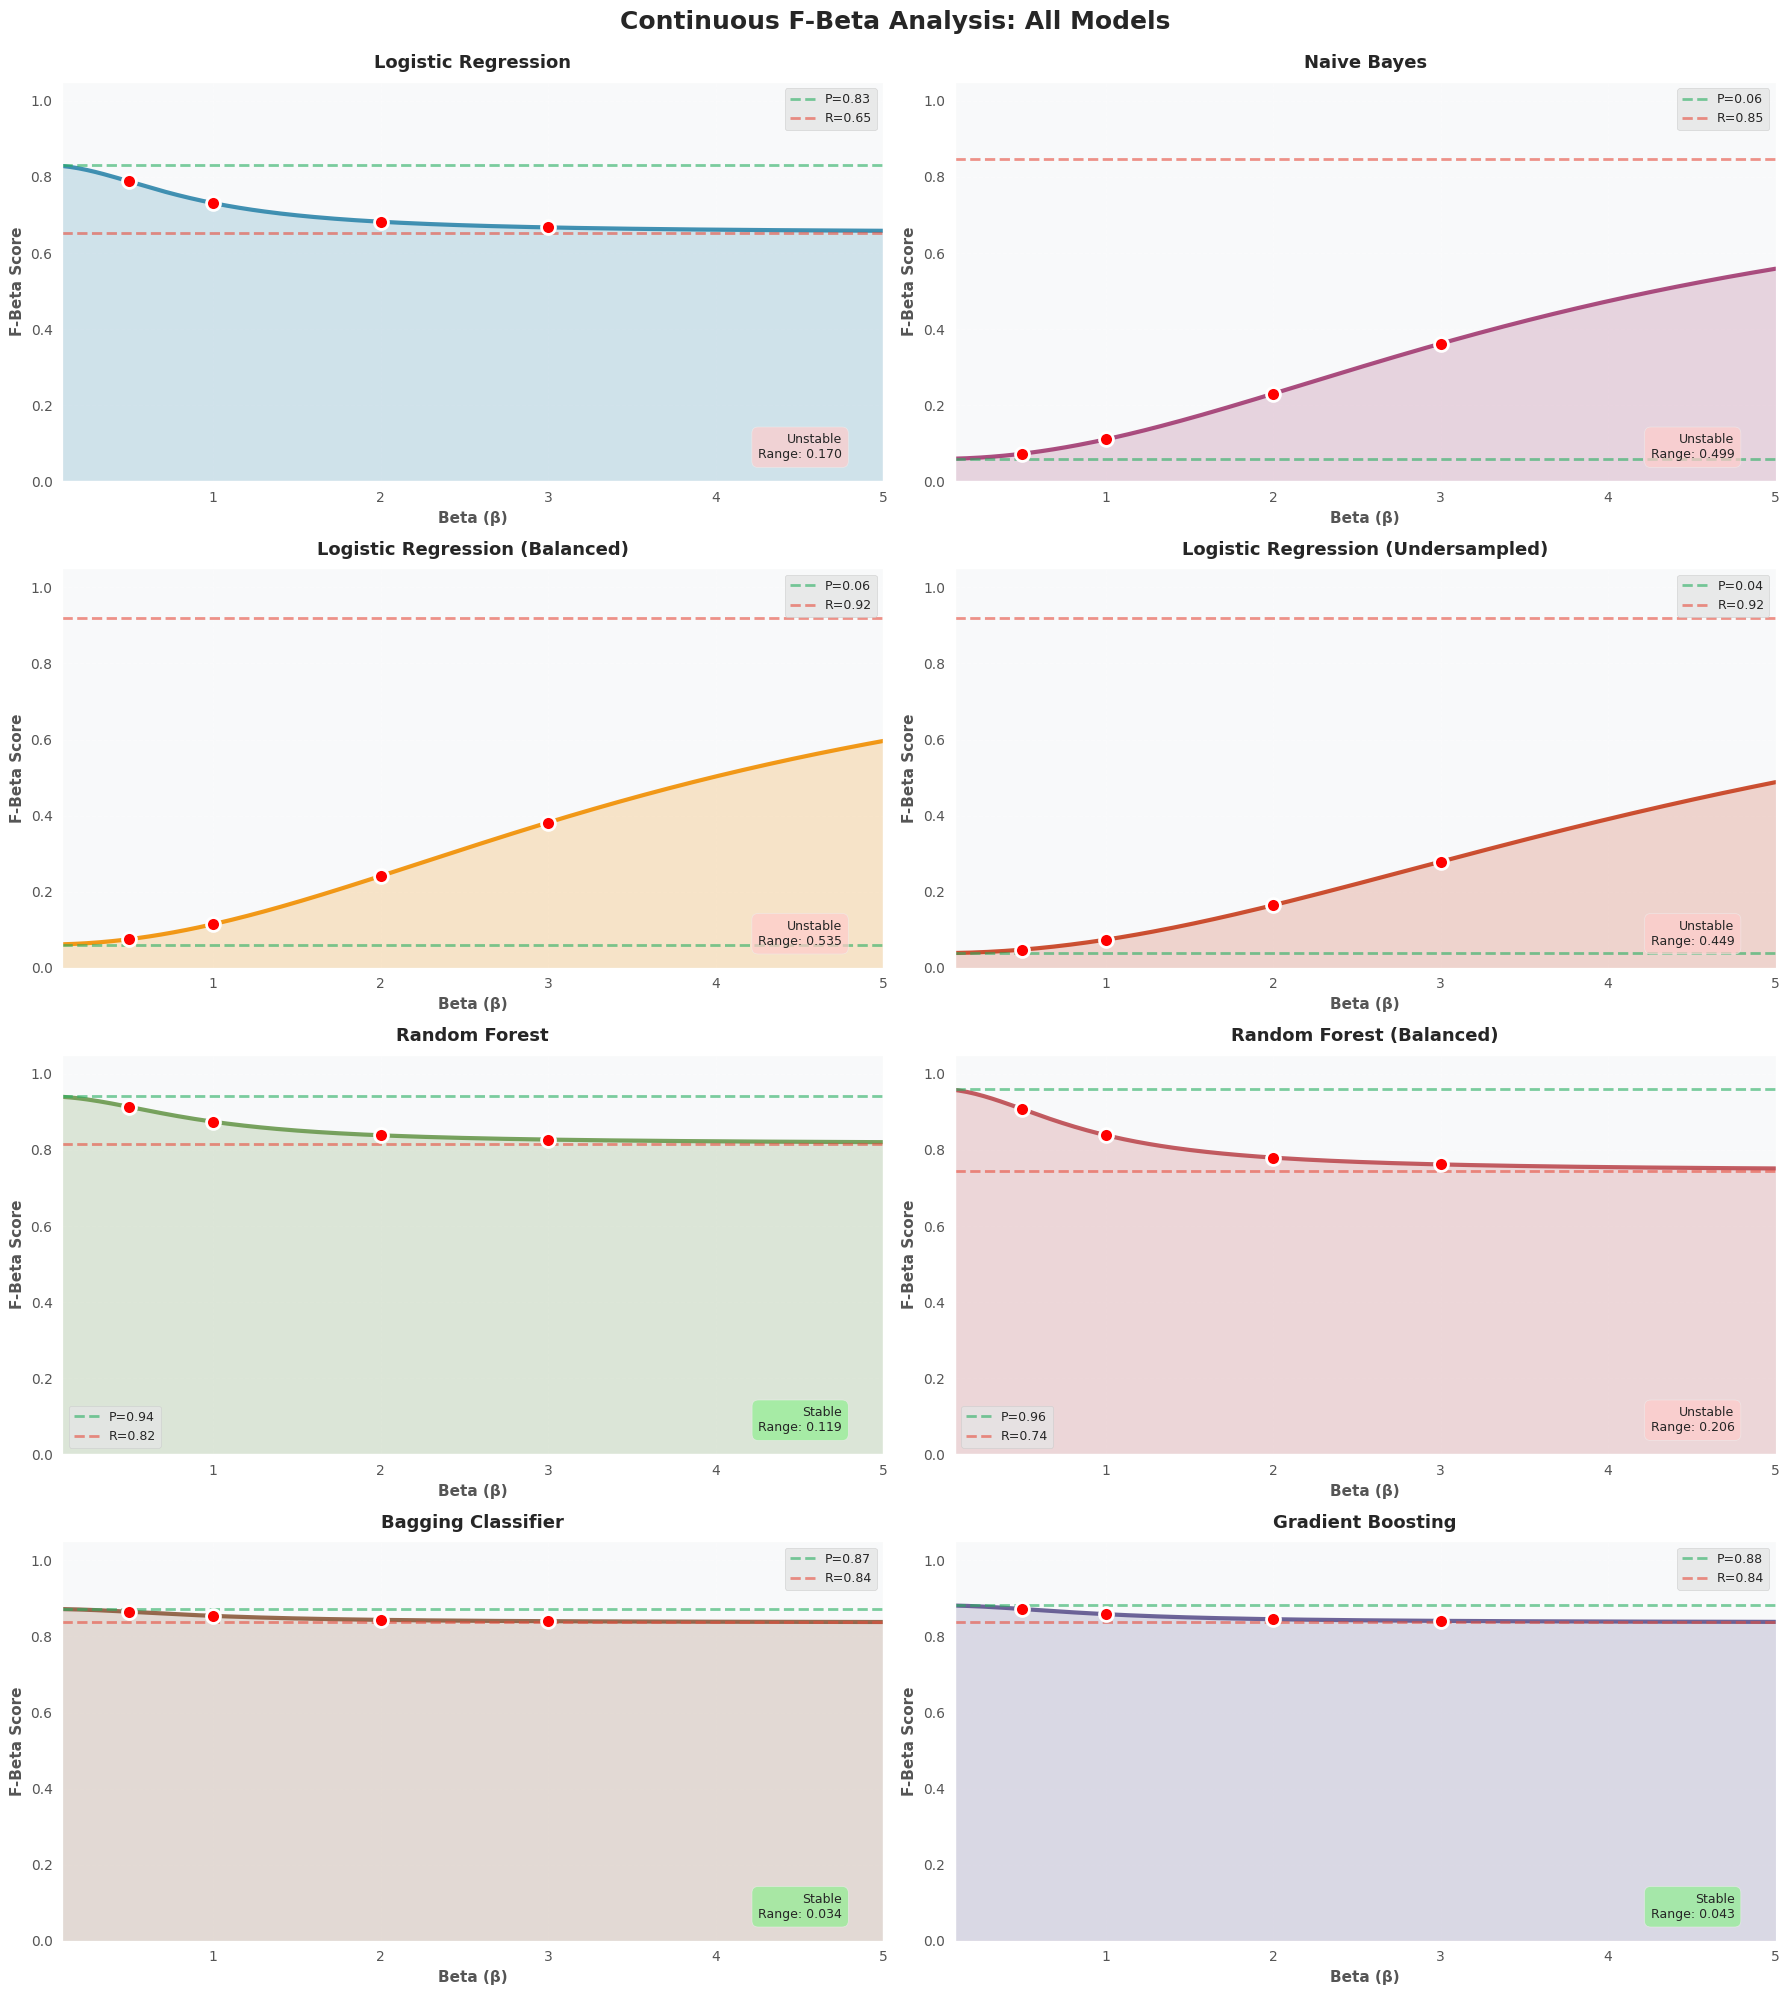

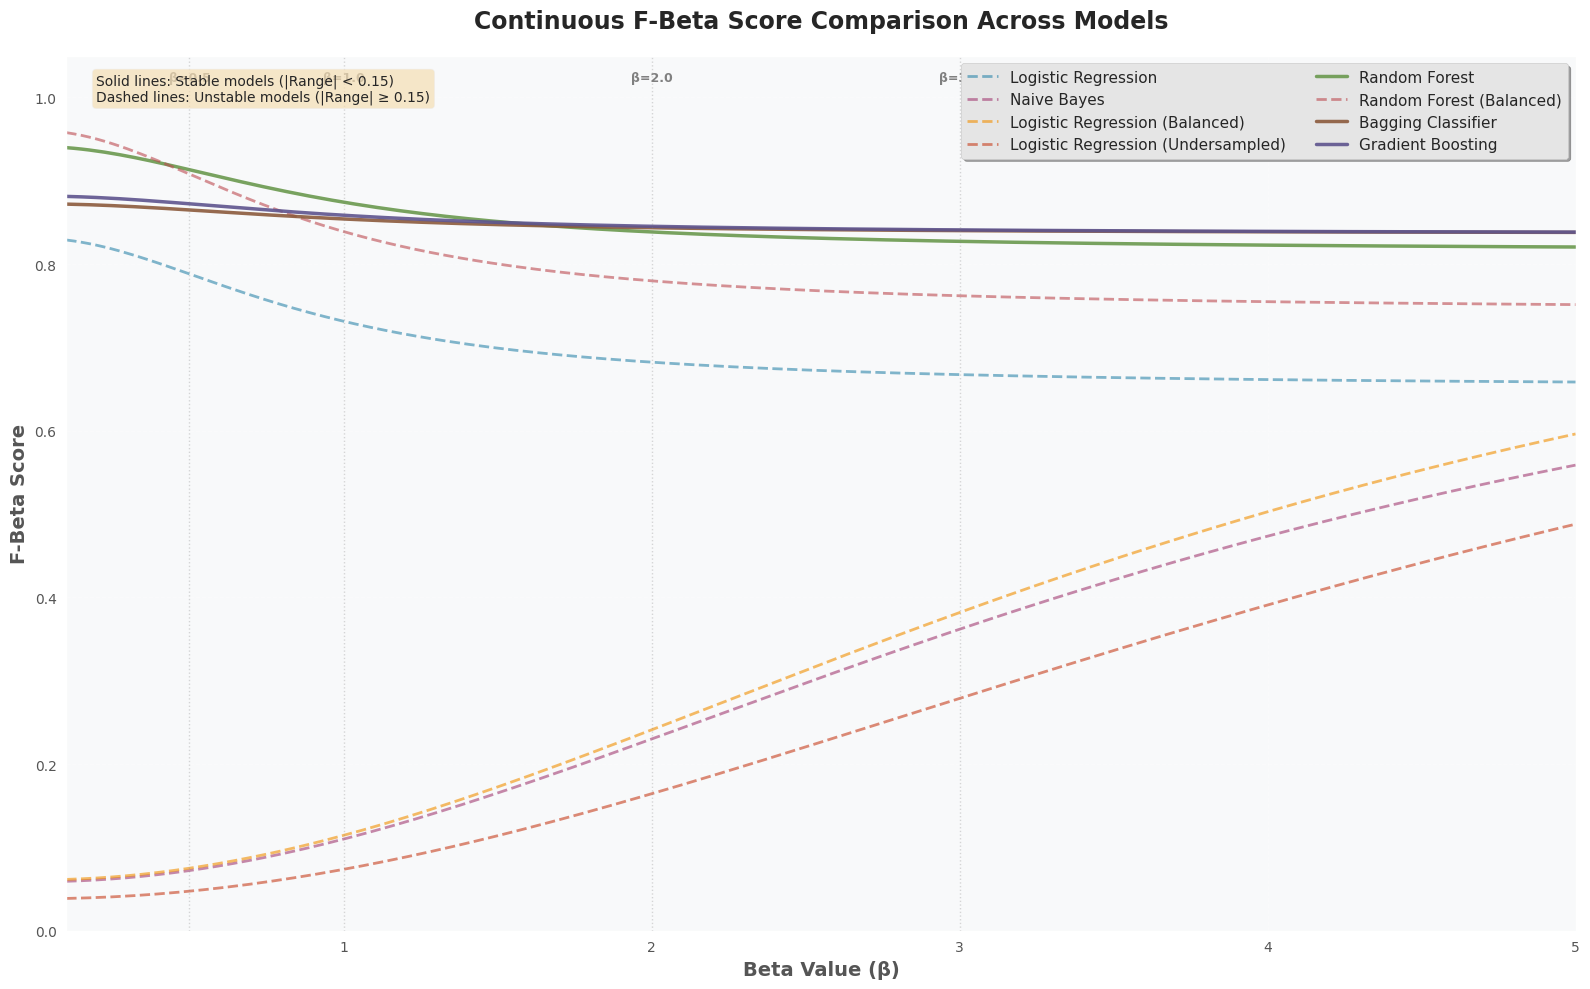

In [55]:
models_for_comparison = {}
for name, result in models.items():
    models_for_comparison[name] = {
        'y_true': y_test,
        'y_pred': result['y_pred']
    }


fig, axes = plot_continuous_fbeta_grid(
    models_dict=models_for_comparison,
    beta_range=(0.1, 5.0),
    num_points=200,
    save_fig=False,
)

fig, ax, all_results = plot_continuous_fbeta_comparison(
    models_dict=models_for_comparison,
    beta_range=(0.1, 5.0),
    num_points=200,
    save_fig=False,
)

An important pattern emerges when analyzing how $F_{\beta}$ scores change with respect to $\beta$. Models can be classified into two distinct behavioral groups based on whether their $F_{\beta}$ scores increase or decrease as $\beta$ increases, revealing fundamental differences in how they handle the precision-recall trade-off.

#### **Models with Increasing $F_{\beta}$ (Recall-Optimized)**

The first group consists of models where $F_{\beta}$ scores increase as $\beta$ increases, exhibiting high sensitivity to $\beta$ variations. This group includes Logistic Regression (Balanced), Logistic Regression (Undersampled), and Naive Bayes. These models share a common characteristic: very low precision (4-6%) but high recall (85-92%), meaning they generate a large number of false positives while successfully detecting most fraudulent transactions. 

Starting with very low precision, these models benefit from higher $\beta$ values because as $\beta$ increases, the $F_{\beta}$ metric places more weight on recall (which is high) while simultaneously decreasing the penalty for low precision. This results in dramatically increasing $F_{\beta}$ scores as $\beta$ grows. The steep positive slope in their $F_{\beta}$ curves reflects this extreme trade-off: they have sacrificed precision almost entirely to maximize recall, making them highly sensitive to changes in evaluation priorities.

#### **Models with Decreasing $F_{\beta}$ (Balanced Models)**

In contrast, the second group shows $F_{\beta}$ scores that decrease or remain relatively stable as $\beta$ increases, exhibiting low sensitivity to $\beta$ variations. This group includes Random Forest (Standard), Random Forest (Balanced), Bagging with Decision Trees, and Gradient Boosting. These models maintain high precision (87-96%) and good recall (74-84%), representing a well-balanced approach to fraud detection.

Starting with excellent precision values, these models experience slight decreases in $F_{\beta}$ as $\beta$ increases because the metric increasingly emphasizes recall over precision. However, since their recall is good but not exceptional compared to the recall-optimized models, the decrease is gradual. The relatively flat or gently declining curves indicate stability: these models maintain consistent performance regardless of whether precision or recall is prioritized. The exception is Random Forest (Balanced), which shows slightly more sensitivity for small $\beta$ values, though it still remains far more stable than the recall-optimized models.

#### **Trade-off Management**

The key distinction between these groups lies in how each handles the precision-recall trade-off. Recall-optimized models have made extreme sacrifices in precision to achieve high recall, and their sensitivity to $\beta$ reveals this imbalance, they perform poorly when precision matters but excel when recall is paramount. Balanced models, on the other hand, successfully maintain both metrics at reasonable levels, and their insensitivity to $\beta$ demonstrates they haven't over-optimized for either metric, making them more robust and production-ready.

For fraud detection applications, balanced models are preferable because they minimize customer friction through few false positives while still catching the majority of fraudulent transactions, all without requiring dramatic adjustments based on changing business priorities. This stability across different $\beta$ values serves as a quality indicator: models that maintain consistent performance demonstrate they've learned genuine fraud patterns rather than simply biasing their predictions toward one class.